<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/main/UFC_Automated_Scoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Data Scraping

The goal of this notebook is to:
* Explore the FightMetrics webpage to scrape the fight and fighter information we need
* Preprocess the data
* Store the fight and fighter data into csv files

Functional as of April 2021

In [1]:
# NUM_EVENTS_INPUT = "All"  #@param {type:"string"}
NUM_EVENTS_INPUT = "10"  #@param {type:"string"}
DATA_MODE_INPUT = "Round by Round"  #@param {type:"string"} #changed from Summary

In [2]:
NUM_EVENTS = None if NUM_EVENTS_INPUT == "All" else int(NUM_EVENTS_INPUT)
ROUND_BY_ROUND = (DATA_MODE_INPUT == "Round by Round")

## Get information about all fighters

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
from string import ascii_lowercase
from bs4 import BeautifulSoup
import requests

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Set parameters for dataset creation

NUM_EVENTS_INPUT: Integer number of UFC events to get fights from or "All" for all events. There are about 10 fights per event.

DATA_MODE_INPUT: Either "Summary" or "Round by Round". Either get data with columns that are summaries of the whole fight, or summaries round-by-round (more columns).

In [4]:
def get_all_fighters():
    '''Get pandas table of all UFC fighters (Name, Height, Weight, Reach, Record, etc.)'''
    all_fighters_tables = []
    for c in tqdm(ascii_lowercase):
        all_fighters_url = f"http://ufcstats.com/statistics/fighters?char={c}&page=all"
        all_fighters_table = pd.read_html(all_fighters_url)[0]
        all_fighters_tables.append(all_fighters_table)

    all_fighters = pd.concat(all_fighters_tables)
    return all_fighters

In [5]:
ALL_FIGHTERS = get_all_fighters()
ALL_FIGHTERS.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:29<00:00,  1.15s/it]


First     Last      Nickname     Ht.       Wt.  Reach    Stance     W  \
0      NaN      NaN           NaN     NaN       NaN    NaN       NaN   NaN   
1      Tom    Aaron           NaN      --  155 lbs.     --       NaN   5.0   
2    Danny   Abbadi  The Assassin  5' 11"  155 lbs.     --  Orthodox   4.0   
3  Nariman  Abbasov     Bayraktar   5' 8"  155 lbs.  66.0"  Orthodox  28.0   
4    David   Abbott          Tank   6' 0"  265 lbs.     --    Switch  10.0   

      L    D  Belt  
0   NaN  NaN   NaN  
1   3.0  0.0   NaN  
2   6.0  0.0   NaN  
3   4.0  0.0   NaN  
4  15.0  0.0   NaN

In [6]:
ALL_FIGHTERS.dtypes

First        object
Last         object
Nickname     object
Ht.          object
Wt.          object
Reach        object
Stance       object
W           float64
L           float64
D           float64
Belt        float64
dtype: object

## Clean fighter data

TODO: Convert height, weight, reach to floats.

In [7]:
ALL_FIGHTERS = ALL_FIGHTERS.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan
ALL_FIGHTERS.dropna(subset=["First", "Last"], how='all')  # Remove rows with no name
ALL_FIGHTERS.head()

First     Last      Nickname     Ht.       Wt.  Reach    Stance     W  \
0      NaN      NaN           NaN     NaN       NaN    NaN       NaN   NaN   
1      Tom    Aaron           NaN     NaN  155 lbs.    NaN       NaN   5.0   
2    Danny   Abbadi  The Assassin  5' 11"  155 lbs.    NaN  Orthodox   4.0   
3  Nariman  Abbasov     Bayraktar   5' 8"  155 lbs.  66.0"  Orthodox  28.0   
4    David   Abbott          Tank   6' 0"  265 lbs.    NaN    Switch  10.0   

      L    D  Belt  
0   NaN  NaN   NaN  
1   3.0  0.0   NaN  
2   6.0  0.0   NaN  
3   4.0  0.0   NaN  
4  15.0  0.0   NaN

## Helper functions

In [8]:
def get_fighters(fighters_string):
    '''Parses string containing two fighter names. Uses ALL_FIGHTERS global to remove ambiguity in parsing. Returns each fighter name
       Eg. "Robert Whittaker Kelvin Gastelum" => ("Robert Whittaker", "Kelvin Gastelum")'''
    first_fighter = ""
    second_fighter = ""
    for i, row in ALL_FIGHTERS.iterrows():
        fighter_name = f'{row["First"]} {row["Last"]}'
        if fighters_string.startswith(fighter_name):
            first_fighter = fighter_name
            second_fighter = fighters_string[len(fighter_name)+1:]
            break
    return first_fighter, second_fighter

def remove_duplicates_keep_order(list_):
    '''Removes duplicates while keeping same order'''
    return list(dict.fromkeys(list_))

## Get a list of all UFC events

In [9]:
from urllib.request import urlopen
from string import ascii_uppercase
from dateutil import parser
from datetime import datetime

In [10]:
ALL_PAST_EVENTS_URL = "http://ufcstats.com/statistics/events/completed?page=all"

In [11]:
def get_all_events(all_past_events_url):
    '''Takes in URL to all past events. Returns list of urls, each one representing a UFC event'''
    all_past_events_html = urlopen(all_past_events_url).read().decode("utf-8")
    
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/event-details/27541033b97c076d"
    pattern = "\"http://ufcstats.com/event-details/[a-zA-Z0-9_]+\""
    all_urls = re.findall(pattern, all_past_events_html)

    # Remove quotes and duplicates
    all_urls = [url.strip("\"") for url in all_urls]
    all_urls = remove_duplicates_keep_order(all_urls)
    return all_urls

In [12]:
# Events
ALL_EVENT_URLS = get_all_events(ALL_PAST_EVENTS_URL)
print(f"Got {len(ALL_EVENT_URLS)} events")
print()

print("Removing the most recent event, since it might not have happened yet")
#ALL_EVENT_URLS = ALL_EVENT_URLS[1:] CHANGE ME BACK LATER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ALL_EVENT_URLS = ALL_EVENT_URLS[1:]
print(f"Now got {len(ALL_EVENT_URLS)} events")
print(ALL_EVENT_URLS)

Got 654 events

Removing the most recent event, since it might not have happened yet
Now got 653 events
['http://ufcstats.com/event-details/6085ceb59087514b', 'http://ufcstats.com/event-details/e9e1acc96536bb4f', 'http://ufcstats.com/event-details/a780d16cf7eed44d', 'http://ufcstats.com/event-details/b9415726dc3ec526', 'http://ufcstats.com/event-details/b6c6d1731ff00eeb', 'http://ufcstats.com/event-details/7abe471b61725980', 'http://ufcstats.com/event-details/6f812143641ceff8', 'http://ufcstats.com/event-details/901cddcbfa079097', 'http://ufcstats.com/event-details/3c6976f8182d9527', 'http://ufcstats.com/event-details/51b1e2fd9872005b', 'http://ufcstats.com/event-details/6fb1ba67bef41b37', 'http://ufcstats.com/event-details/15b1b21cd743d652', 'http://ufcstats.com/event-details/3dc3022232b79c7a', 'http://ufcstats.com/event-details/aec273fcb765330d', 'http://ufcstats.com/event-details/e4bb7e483c4ad318', 'http://ufcstats.com/event-details/35080a7f406f9ab3', 'http://ufcstats.com/event-deta

## Get a list of all UFC events from MMA Decisions

In [13]:
def get_all_mma_decision_events():
    '''Takes in URL to all past events, goes through each year and returns list if urls, each representing 
        a past event from MMA Decicions from newest to oldest'''
    all_href_event_links = []
    for year in range(2023, 1994, -1):
        all_yearly_events_url = f"http://mmadecisions.com/decisions-by-event/{year}/"
        response = requests.get(all_yearly_events_url)
        soup = BeautifulSoup(response.content, "html.parser")
        links = soup.find_all("a", href=lambda href: href and "UFC" in href)
        href_list = [link["href"] for link in links]
        all_href_event_links.extend(href_list)
    #all_href_event_links = list(chain.from_iterable(all_href_event_links))
    return all_href_event_links

## Get a list of UFC fights from MMA Decisions

In [14]:
def get_all_mma_decision_fights_in_event(past_event_url):
    '''Takes in a single URL to a past MMA Decision event.
        return fight_urls'''
    response = requests.get(past_event_url)
    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a", href=lambda href: href and "decision/" in href)
    href_list = [link["href"] for link in links]
    return href_list

In [15]:
def get_all_fights_in_mma_decision(all_mma_event_urls, num_events=None):
    '''Takes in list of URLs to past events. Return list: urls representing a UFC fight.
    Set num_events to be the number of events to get fights from. Set to None if want all.'''
    if num_events is None:
        num_events = len(all_mma_event_urls)
    
    all_fight_urls = []
    for i, event_url in enumerate(tqdm(all_mma_event_urls[:num_events])):
        # For each event, get the fight urls and winners
        event_url = "http://mmadecisions.com/" + event_url
        fight_urls = get_all_mma_decision_fights_in_event(event_url)
        all_fight_urls.extend(fight_urls)

    return all_fight_urls

In [16]:
all_event_urls = get_all_mma_decision_events()
all_fights_urls = get_all_fights_in_mma_decision(all_event_urls, NUM_EVENTS)
all_fights_urls

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


['decision/14130/Alexandre-Pantoja-vs-Brandon-Moreno\r\n',
 'decision/14128/Dan-Hooker-vs-Jalin-Turner\r\n',
 'decision/14125/Tatsuro-Taira-vs-Edgar-Chairez\r\n',
 'decision/14119/Esteban-Ribovics-vs-Kamuela-Kirk\r\n',
 'decision/14115/Grant-Dawson-vs-Damir-Ismagulov\r\n',
 'decision/14114/Michael-Morales-vs-Max-Griffin\r\n',
 'decision/14113/Ariane-Lipski-vs-Melissa-Gatto\r\n',
 'decision/14108/Karol-Rosa-vs-Yana-Santos\r\n',
 'decision/14106/Luana-Carolina-vs-Ivana-Petrovic\r\n',
 'decision/14105/Alexander-Romanov-vs-Blagoy-Ivanov\r\n',
 'decision/14104/Ilia-Topuria-vs-Josh-Emmett\r\n',
 'decision/14099/Neil-Magny-vs-Philip-Rowe\r\n',
 'decision/14098/Randy-Brown-vs-Wellington-Turman\r\n',
 'decision/14096/Tabatha-Ricci-vs-Gillian-Robertson\r\n',
 'decision/14095/Josh-Van-vs-Zhalgas-Zhumagulov\r\n',
 'decision/14094/Chepe-Mariscal-vs-Trevor-Peek\r\n',
 'decision/14093/Jack-Jenkins-vs-Jamall-Emmers\r\n',
 'decision/14092/Sedriques-Dumas-vs-Cody-Brundage\r\n',
 'decision/14086/Jared-Ca

## Get a list of UFC fights

TODO: Right now only sees if result is win. Else sets winner to None. See if this can be improved.

In [17]:
def get_all_fights_in_event(past_event_url, get_results=False):
    '''Takes in a single URL to a past event.
       If get_results=True, returns fight_urls, winners, methods
       else, return fight_urls'''
    # Regex for "http://ufcstats.com/events-details/<alphanumeric>"
    # Eg. "http://ufcstats.com/fight-details/f67aa0b16e16a9ea"
    past_event_html = urlopen(past_event_url).read().decode("utf-8")
    pattern = "\"http://ufcstats.com/fight-details/[a-zA-Z0-9_]+\""
    fight_urls = re.findall(pattern, past_event_html)

    # Remove quotes and duplicates
    fight_urls = [url.strip("\"") for url in fight_urls]
    fight_urls = remove_duplicates_keep_order(fight_urls)

    # Get the winner and method (dec or KO or sub) of each fight
    past_event_table = pd.read_html(past_event_url)[0]  # Will be length 1 list
    winners, methods = [], []
    for _, row in past_event_table.iterrows():
        # TODO: Improve this processing of result
        result = row["W/L"].split(' ')[0]
        if result == "win":
            winner, _ = get_fighters(row["Fighter"])
        else:
            winner = None
        winners.append(winner)
        methods.append(row["Method"])

    if get_results:
        return fight_urls, winners, methods
    else:
        return fight_urls

In [18]:
def get_all_fights(all_event_urls, num_events=None):
    '''Takes in list of URLs to past events. Returns 3 lists: urls, winners, methods, each representing a UFC fight.
       Set num_events to be the number of events to get fights from. Set to None if want all.'''
    if num_events is None:
        num_events = len(all_event_urls)
    
    all_fight_urls, all_winners, all_methods = [], [], []
    for i, event_url in enumerate(tqdm(all_event_urls[:num_events])):
        # For each event, get the fight urls and winners
        fight_urls, winners, methods = get_all_fights_in_event(event_url, get_results=True)
        all_fight_urls.extend(fight_urls)
        all_winners.extend(winners)
        all_methods.extend(methods)
    return all_fight_urls, all_winners, all_methods

In [19]:
FIGHT_URLS, WINNERS, METHODS = get_all_fights(ALL_EVENT_URLS, num_events=NUM_EVENTS)
print(f"Got {len(FIGHT_URLS)} fights")
print(FIGHT_URLS)
print(WINNERS)
print(METHODS)

assert(len(FIGHT_URLS) == len(WINNERS))
assert(len(FIGHT_URLS) == len(METHODS))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.51s/it]

Got 120 fights
['http://ufcstats.com/fight-details/4b12a4b48755cd6b', 'http://ufcstats.com/fight-details/0f24f3bc1b39ea45', 'http://ufcstats.com/fight-details/4ec5d9bd1442e6c1', 'http://ufcstats.com/fight-details/b6ea8880cc7af439', 'http://ufcstats.com/fight-details/1ffe6e8df6dbefd2', 'http://ufcstats.com/fight-details/20d8f6b4b7c8bae7', 'http://ufcstats.com/fight-details/d3a9aceeb7e23580', 'http://ufcstats.com/fight-details/ef270d8cf29d071b', 'http://ufcstats.com/fight-details/6ef12db5b099ec81', 'http://ufcstats.com/fight-details/69f67a4a690eb15d', 'http://ufcstats.com/fight-details/dbf8a4b0870a47d1', 'http://ufcstats.com/fight-details/420f7e6530dbc727', 'http://ufcstats.com/fight-details/5b71958ee063a6e8', 'http://ufcstats.com/fight-details/f557405652165aa3', 'http://ufcstats.com/fight-details/4dc5a41f357a7d85', 'http://ufcstats.com/fight-details/0548a24a9bf8d7a0', 'http://ufcstats.com/fight-details/ea29714dcfb07ce2', 'http://ufcstats.com/fight-details/cd137988da724076', 'http://ufcs

## Get fight tables


In [20]:
def get_labeled_fight_tables(fight_url):
    '''Convert fight url to dictionary of pandas tables of information.
       Before, gave a list of tables that was hard to understand.
       Now have Totals, Per Round Totals, Significant Strikes, Per Round Significant Strikes'''
    fight_tables = pd.read_html(fight_url)
    
    labeled_fight_tables = {}
    labeled_fight_tables['Totals'] = fight_tables[0]
    labeled_fight_tables['Per Round Totals'] = fight_tables[1]
    labeled_fight_tables['Significant Strikes'] = fight_tables[2]
    labeled_fight_tables['Per Round Significant Strikes'] = fight_tables[3]
    return labeled_fight_tables

In [21]:
RAW_FIGHT_TABLES_LIST = []
for url in tqdm(FIGHT_URLS):
    RAW_FIGHT_TABLES_LIST.append(get_labeled_fight_tables(url))

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:29<00:00,  1.35it/s]


In [22]:
RAW_FIGHT_TABLES_LIST[0]['Totals'].head()

Fighter    KD           Sig. str. Sig. str. %  \
0  Alexander Volkanovski Yair Rodriguez  0  0  66 of 97  40 of 80    68%  50%   

              Total str.               Td      Td % Sub. att  Rev.        Ctrl  
0  149 of 198  57 of 103  7 of 12  0 of 0  58%  ---     0  0  0  0  7:13  0:00

In [23]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Totals'].head()

Fighter      KD           Sig. str.  \
                                Round 1 Round 1             Round 1   
                                Round 2 Round 2             Round 2   
                                Round 3 Round 3             Round 3   
0  Alexander Volkanovski Yair Rodriguez    0  0    11 of 15  5 of 9   
1  Alexander Volkanovski Yair Rodriguez    0  0  18 of 25  12 of 19   
2  Alexander Volkanovski Yair Rodriguez    0  0  37 of 57  23 of 52   

  Sig. str. %          Total str.            Td %           Sub. att    Rev.  \
      Round 1             Round 1         Round 1            Round 1 Round 1   
      Round 2             Round 2         Round 2            Round 2 Round 2   
      Round 3             Round 3         Round 3 Round 3.1  Round 3 Round 3   
0    73%  55%  49 of 58  10 of 15  3 of 4  0 of 0  75%  ---     0  0    0  0   
1    72%  63%  55 of 75  24 of 36  3 of 6  0 of 0  50%  ---     0  0    0  0   
2    64%  44%  45 of 65  23 of 52  1 of 2  0 of 0  50%  ---     0  0    0  0   

         Ctrl  
      Round 1  
      Round 2  
      Round 3  
0  3:22  0:00  
1  3:33  0:00  
2  0:18  0:00

In [24]:
RAW_FIGHT_TABLES_LIST[0]['Significant Strikes'].head()

Fighter            Sig. str Sig. str. %  \
0  Alexander Volkanovski Yair Rodriguez  66 of 97  40 of 80    68%  50%   

                 Head              Body                 Leg  \
0  48 of 69  13 of 49  4 of 5  11 of 14  14 of 23  16 of 17   

             Distance          Clinch            Ground  
0  25 of 45  38 of 77  4 of 6  0 of 0  37 of 46  2 of 3

In [25]:
RAW_FIGHT_TABLES_LIST[0]['Per Round Significant Strikes'].head()

Fighter            Sig. str Sig. str. %  \
                                Round 1             Round 1     Round 1   
                                Round 2             Round 2     Round 2   
                                Round 3             Round 3     Round 3   
0  Alexander Volkanovski Yair Rodriguez    11 of 15  5 of 9    73%  55%   
1  Alexander Volkanovski Yair Rodriguez  18 of 25  12 of 19    72%  63%   
2  Alexander Volkanovski Yair Rodriguez  37 of 57  23 of 52    64%  44%   

                Head            Body                 Leg            Distance  \
             Round 1         Round 1             Round 1             Round 1   
             Round 2         Round 2             Round 2             Round 2   
             Round 3         Round 3             Round 3             Round 3   
0    9 of 11  1 of 4  0 of 0  1 of 1      2 of 4  3 of 4      2 of 4  4 of 8   
1  15 of 19  4 of 10  1 of 1  5 of 6      2 of 5  3 of 3   4 of 10  11 of 17   
2  24 of 39  8 of 35  3 of 4  5 of 7  10 of 14  10 of 10  19 of 31  23 of 52   

           Clinch            Ground Unnamed: 9_level_0  
          Round 1           Round 1            Round 1  
          Round 2           Round 2            Round 2  
          Round 3           Round 3            Round 3  
0  0 of 0  0 of 0   9 of 11  1 of 1                NaN  
1  1 of 1  0 of 0  13 of 14  1 of 2                NaN  
2  3 of 5  0 of 0  15 of 21  0 of 0                NaN

In [26]:
display(RAW_FIGHT_TABLES_LIST)

[{'Totals':                                 Fighter    KD           Sig. str. Sig. str. %  \
  0  Alexander Volkanovski Yair Rodriguez  0  0  66 of 97  40 of 80    68%  50%   
  
                Total str.               Td      Td % Sub. att  Rev.        Ctrl  
  0  149 of 198  57 of 103  7 of 12  0 of 0  58%  ---     0  0  0  0  7:13  0:00  ,
  'Per Round Totals':                                 Fighter      KD           Sig. str.  \
                                  Round 1 Round 1             Round 1   
                                  Round 2 Round 2             Round 2   
                                  Round 3 Round 3             Round 3   
  0  Alexander Volkanovski Yair Rodriguez    0  0    11 of 15  5 of 9   
  1  Alexander Volkanovski Yair Rodriguez    0  0  18 of 25  12 of 19   
  2  Alexander Volkanovski Yair Rodriguez    0  0  37 of 57  23 of 52   
  
    Sig. str. %          Total str.            Td %           Sub. att    Rev.  \
        Round 1             Round 1   

## Clean fight information

Separate each fighter's information into a different column

TODO: Lots of stuff to improve. Smarter use of Totals, round by round, and significant strikes. Can also use non integer information, total attempted strikes (not just landed), fighter information, etc. All of those being ignored right now. Find nice way to parse new information round by round. Handle no winner case better. May need to add ignore_index=True for pd.concat

In [27]:
def parse_string(row_string):
    '''Break string into two parts: one for fighter 0 and one for fighter 1
       Eg. 150 of 284  62 of 209 => (150 of 284, 62 of 209)'''
    if not isinstance(row_string, str):
        return "0", "0"
    string_split = row_string.split(" ")
    first_fighter_stat = " ".join(string_split[:len(string_split)//2])
    second_fighter_stat = " ".join(string_split[len(string_split)//2+1:])
    return first_fighter_stat, second_fighter_stat

In [28]:
def convert_to_int_or_double_if_possible(string):
    '''Convert string to int or double if possible
       If has a percent sign, tries to remove it and continue.'''
    def isfloat(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # If input is not string, then return it unchanged
    if not isinstance(string, str):
        return string

    # Remove %
    if "%" in string:
        string = string.strip("%")

    # Convert to int or float
    if isfloat(string) and float(string).is_integer():
        return int(string)
    if isfloat(string):
        return float(string)
    return string

In [29]:
def process_fight(raw_fight_table):
    '''Takes in a raw, one-row pandas fight table. Returns a pandas dataframe representing the fight statistics'''    
    # Break up columns.
    # Eg. "Name" => "Fighter 0 Name", "Fighter 1 Name"
    # "KD" => "Fighter 0 KD", "Fighter 1 KD"
    new_columns = []
    for column in raw_fight_table.columns:
        new_columns.append(f"Fighter 0 {column}")
        new_columns.append(f"Fighter 1 {column}")
        
    # Go through each row and break up the data into the columns
    new_rows = []
    for i, row in raw_fight_table.iterrows():
        new_row = []
        for column in raw_fight_table.columns:
            # Split string at the center space
            stat1, stat2 = parse_string(row[column])

            # TODO: Update this to capture more information

            # Has "100 of 120" type stat. Just store first number
            if " of " in stat1:
                stat1 = stat1.split(" of ")[0]
            if " of " in stat2:
                stat2 = stat2.split(" of ")[0]

            # Has "2:32" type stat (min:sec). Convert to sec.
            if len(re.findall("^[0-9]+:[0-9]+$", stat1)) > 0:
                min1, sec1 = stat1.split(":")[0], stat1.split(":")[1]
                stat1 = convert_to_int_or_double_if_possible(min1)*60 + convert_to_int_or_double_if_possible(sec1)
            if len(re.findall("^[0-9]+:[0-9]+$", stat2)) > 0:
                min2, sec2 = stat2.split(":")[0], stat2.split(":")[1]
                stat2 = convert_to_int_or_double_if_possible(min2)*60 + convert_to_int_or_double_if_possible(sec2)
            
            # Convert string to float or int if possible
            stat1 = convert_to_int_or_double_if_possible(stat1)
            stat2 = convert_to_int_or_double_if_possible(stat2)

            # Add to row
            new_row.append(stat1)
            new_row.append(stat2)
        new_rows.append(new_row)

    # Bring together into new dataframe, then only store the numerical values
    # TODO: Process better to keep more info, not throw so much away
    df = pd.DataFrame(new_rows, columns=new_columns)

    # Add in names, using smarter parsing
    df = df.drop(columns=['Fighter 0 Fighter', 'Fighter 1 Fighter'])
    fighters_string = raw_fight_table["Fighter"][0]  # Only 1 row table
    print(fighters_string)
    fighter0, fighter1 = get_fighters(fighters_string)
    df['Fighter 0 Name'] = fighter0
    df['Fighter 1 Name'] = fighter1
    return df

In [30]:
def process_raw_fight_tables(raw_fight_tables, winner, method, round_by_round=False):
    '''Takes in set of raw fight table (one fight), the name of the fight winner, and the method of winning. Returns a cleaned pandas table.
       Set round_by_round=True to use the round-by-round data. Otherwise, uses full fight stats.'''
    def create_aggregated_fight_table(raw_fight_tables):
        # Aggregate data from multiple tables
        fight_table = process_fight(raw_fight_tables["Totals"])
        fight_table2 = process_fight(raw_fight_tables["Significant Strikes"])
        
        # Rename column names with identical data to match
        fight_table2 = fight_table2.rename(columns={"Fighter 0 Sig. str": "Fighter 0 Sig. str.", "Fighter 1 Sig. str": "Fighter 1 Sig. str."})

        # Bring tables together, then remove duplicates
        fight_table = pd.concat([fight_table, fight_table2], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table

    def create_aggregated_round_by_round_fight_table(raw_fight_tables):
        ##### Aggregate data totals table
        tables = []
        for i, row in raw_fight_tables["Per Round Totals"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Totals"].columns)
            df = pd.DataFrame([values], columns=cols)
 
            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if  c != "Fighter" else c for c in cols]
            df.columns = new_cols

            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight.
        # Then remove duplicates
        totals_df = pd.concat(tables, axis=1)
        totals_df = totals_df.loc[:,~totals_df.columns.duplicated()]

        ##### Aggregate data significant strikes table
        tables = []
        for i, row in raw_fight_tables["Per Round Significant Strikes"].iterrows():
            # Get df of one round
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            cols = list(raw_fight_tables["Significant Strikes"].columns)
            if len(values) != len(cols):
                values = values[:-1]  # Remove last column values, as shown above, has extra column for no reason
            df = pd.DataFrame([values], columns=cols)

            # Update columns with round number
            new_cols = [f"Round {i+1} {c}" if c != "Fighter" else c for c in cols]
            df.columns = new_cols
            tables.append(process_fight(df))
        # Concatenate round-by-round horizontally, so each row is for 1 fight
        # Then remove duplicates
        sig_strikes_df = pd.concat(tables, axis=1)
        sig_strikes_df = sig_strikes_df.loc[:,~sig_strikes_df.columns.duplicated()]
        
        ##### Bring tables together, then remove duplicates
        fight_table = pd.concat([totals_df, sig_strikes_df], axis=1)
        fight_table = fight_table.loc[:,~fight_table.columns.duplicated()]
        return fight_table


    if round_by_round:
        fight_table = create_aggregated_round_by_round_fight_table(raw_fight_tables)
    else:
        fight_table = create_aggregated_fight_table(raw_fight_tables)

    if fight_table["Fighter 0 Name"][0] == winner:
        label = 0
    elif fight_table["Fighter 1 Name"][0] == winner:
        label = 1
    else:
        print(f'ERROR: fight_table["Fighter 0 Name"]={fight_table["Fighter 0 Name"]}, fight_table["Fighter 1 Name"]={fight_table["Fighter 1 Name"]}, winner={winner}')
        label = -1
    fight_table['Winner'] = label
    fight_table['Method'] = method
    return fight_table

In [31]:
FIGHT_TABLE = []
for i in tqdm(range(len(RAW_FIGHT_TABLES_LIST))):
    FIGHT_TABLE.append(process_raw_fight_tables(RAW_FIGHT_TABLES_LIST[i], WINNERS[i], METHODS[i], round_by_round=ROUND_BY_ROUND)) 
FIGHT_TABLE = pd.concat(FIGHT_TABLE, ignore_index=True)
FIGHT_TABLE = FIGHT_TABLE.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Alexander Volkanovski Yair Rodriguez
Alexander Volkanovski Yair Rodriguez
Alexander Volkanovski Yair Rodriguez
Alexander Volkanovski Yair Rodriguez
Alexander Volkanovski Yair Rodriguez
Alexander Volkanovski Yair Rodriguez


  1%|▋                                                                                 | 1/120 [00:01<03:23,  1.71s/it]

Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja
Brandon Moreno Alexandre Pantoja


  2%|█▎                                                                                | 2/120 [00:03<03:27,  1.76s/it]

Robert Whittaker Dricus Du Plessis
Robert Whittaker Dricus Du Plessis
Robert Whittaker Dricus Du Plessis
Robert Whittaker Dricus Du Plessis


  2%|██                                                                                | 3/120 [00:04<02:52,  1.48s/it]

Jalin Turner Dan Hooker
Jalin Turner Dan Hooker
Jalin Turner Dan Hooker
Jalin Turner Dan Hooker
Jalin Turner Dan Hooker
Jalin Turner Dan Hooker


  3%|██▋                                                                               | 4/120 [00:06<02:57,  1.53s/it]

Bo Nickal Val Woodburn
Bo Nickal Val Woodburn


  4%|███▍                                                                              | 5/120 [00:06<02:07,  1.11s/it]

Robbie Lawler Niko Price
Robbie Lawler Niko Price


  5%|████                                                                              | 6/120 [00:06<01:35,  1.20it/s]

Tatsuro Taira Edgar Chairez
Tatsuro Taira Edgar Chairez
Tatsuro Taira Edgar Chairez
Tatsuro Taira Edgar Chairez
Tatsuro Taira Edgar Chairez


  7%|█████▍                                                                            | 8/120 [00:08<01:32,  1.21it/s]

Tatsuro Taira Edgar Chairez
Yazmin Jauregui Denise Gomes
Yazmin Jauregui Denise Gomes
Jimmy Crute Alonzo Menifield


  8%|██████▏                                                                           | 9/120 [00:09<01:11,  1.55it/s]

Jimmy Crute Alonzo Menifield
Jimmy Crute Alonzo Menifield
Jimmy Crute Alonzo Menifield
Vitor Petrino Marcin Prachnio
Vitor Petrino Marcin Prachnio
Vitor Petrino Marcin Prachnio
Vitor Petrino Marcin Prachnio
Vitor Petrino Marcin Prachnio


  8%|██████▊                                                                          | 10/120 [00:10<01:30,  1.21it/s]

Vitor Petrino Marcin Prachnio
Cameron Saaiman Terrence Mitchell


  9%|███████▍                                                                         | 11/120 [00:10<01:17,  1.41it/s]

Cameron Saaiman Terrence Mitchell
Shannon Ross Jesus Aguilar
Shannon Ross Jesus Aguilar


 10%|████████                                                                         | 12/120 [00:11<01:08,  1.59it/s]

Kamuela Kirk Esteban Ribovics
Kamuela Kirk Esteban Ribovics
Kamuela Kirk Esteban Ribovics
Kamuela Kirk Esteban Ribovics
Kamuela Kirk Esteban Ribovics
Kamuela Kirk Esteban Ribovics


 11%|████████▊                                                                        | 13/120 [00:11<01:13,  1.46it/s]

Sean Strickland Abus Magomedov
Sean Strickland Abus Magomedov
Sean Strickland Abus Magomedov


 12%|█████████▍                                                                       | 14/120 [00:13<01:23,  1.27it/s]

Sean Strickland Abus Magomedov
Damir Ismagulov Grant Dawson
Damir Ismagulov Grant Dawson
Damir Ismagulov Grant Dawson
Damir Ismagulov Grant Dawson
Damir Ismagulov Grant Dawson


 12%|██████████▏                                                                      | 15/120 [00:13<01:22,  1.28it/s]

Damir Ismagulov Grant Dawson
Max Griffin Michael Morales
Max Griffin Michael Morales
Max Griffin Michael Morales
Max Griffin Michael Morales
Max Griffin Michael Morales


 13%|██████████▊                                                                      | 16/120 [00:14<01:16,  1.36it/s]

Max Griffin Michael Morales
Ariane Lipski Melissa Gatto
Ariane Lipski Melissa Gatto
Ariane Lipski Melissa Gatto
Ariane Lipski Melissa Gatto
Ariane Lipski Melissa Gatto


 14%|███████████▍                                                                     | 17/120 [00:15<01:21,  1.26it/s]

Ariane Lipski Melissa Gatto
Ismael Bonfim Benoit Saint Denis
Ismael Bonfim Benoit Saint Denis
Brunno Ferreira Nursulton Ruziboev


 16%|████████████▊                                                                    | 19/120 [00:15<00:48,  2.08it/s]

Brunno Ferreira Nursulton Ruziboev
Kevin Lee Rinat Fakhretdinov


 17%|█████████████▌                                                                   | 20/120 [00:15<00:43,  2.29it/s]

Kevin Lee Rinat Fakhretdinov
Joanderson Brito Westin Wilson
Joanderson Brito Westin Wilson
Yana Santos Karol Rosa
Yana Santos Karol Rosa
Yana Santos Karol Rosa
Yana Santos Karol Rosa
Yana Santos Karol Rosa
Yana Santos Karol Rosa


 18%|██████████████▊                                                                  | 22/120 [00:17<00:54,  1.81it/s]

Guram Kutateladze Elves Brener
Guram Kutateladze Elves Brener
Guram Kutateladze Elves Brener
Guram Kutateladze Elves Brener
Guram Kutateladze Elves Brener
Guram Kutateladze Elves Brener


 19%|███████████████▌                                                                 | 23/120 [00:18<01:00,  1.60it/s]

Ivana Petrovic Luana Carolina
Ivana Petrovic Luana Carolina
Ivana Petrovic Luana Carolina
Ivana Petrovic Luana Carolina
Ivana Petrovic Luana Carolina


 20%|████████████████▏                                                                | 24/120 [00:19<01:14,  1.29it/s]

Ivana Petrovic Luana Carolina
Alexandr Romanov Blagoy Ivanov
Alexandr Romanov Blagoy Ivanov
Alexandr Romanov Blagoy Ivanov
Alexandr Romanov Blagoy Ivanov
Alexandr Romanov Blagoy Ivanov


 21%|████████████████▉                                                                | 25/120 [00:20<01:27,  1.09it/s]

Alexandr Romanov Blagoy Ivanov
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria
Josh Emmett Ilia Topuria


 22%|█████████████████▌                                                               | 26/120 [00:21<01:21,  1.15it/s]

Amanda Ribas Maycee Barber
Amanda Ribas Maycee Barber
Amanda Ribas Maycee Barber


 22%|██████████████████▏                                                              | 27/120 [00:22<01:20,  1.16it/s]

Amanda Ribas Maycee Barber
Austen Lane Justin Tafa


 23%|██████████████████▉                                                              | 28/120 [00:22<01:04,  1.42it/s]

Austen Lane Justin Tafa
ERROR: fight_table["Fighter 0 Name"]=0    Austen Lane
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Justin Tafa
Name: Fighter 1 Name, dtype: object, winner=None
David Onama Gabriel Santos
David Onama Gabriel Santos
David Onama Gabriel Santos


 24%|███████████████████▌                                                             | 29/120 [00:23<01:05,  1.38it/s]

David Onama Gabriel Santos
Brendan Allen Bruno Silva
Brendan Allen Bruno Silva
Neil Magny Phil Rowe
Neil Magny Phil Rowe
Neil Magny Phil Rowe
Neil Magny Phil Rowe
Neil Magny Phil Rowe
Neil Magny Phil Rowe


 27%|█████████████████████▌                                                           | 32/120 [00:24<00:46,  1.90it/s]

Randy Brown Wellington Turman
Randy Brown Wellington Turman
Randy Brown Wellington Turman
Randy Brown Wellington Turman
Randy Brown Wellington Turman
Randy Brown Wellington Turman
Mateusz Rebecki Loik Radzhabov
Mateusz Rebecki Loik Radzhabov
Mateusz Rebecki Loik Radzhabov


 28%|██████████████████████▎                                                          | 33/120 [00:25<00:52,  1.65it/s]

Mateusz Rebecki Loik Radzhabov
Tabatha Ricci Gillian Robertson
Tabatha Ricci Gillian Robertson
Tabatha Ricci Gillian Robertson
Tabatha Ricci Gillian Robertson
Tabatha Ricci Gillian Robertson


 28%|██████████████████████▉                                                          | 34/120 [00:26<01:07,  1.27it/s]

Tabatha Ricci Gillian Robertson
Zhalgas Zhumagulov Joshua Van
Zhalgas Zhumagulov Joshua Van
Zhalgas Zhumagulov Joshua Van
Zhalgas Zhumagulov Joshua Van
Zhalgas Zhumagulov Joshua Van
Zhalgas Zhumagulov Joshua Van


 29%|███████████████████████▋                                                         | 35/120 [00:28<01:29,  1.05s/it]

Trevor Peek Chepe Mariscal
Trevor Peek Chepe Mariscal
Trevor Peek Chepe Mariscal
Trevor Peek Chepe Mariscal
Trevor Peek Chepe Mariscal
Trevor Peek Chepe Mariscal


 30%|████████████████████████▎                                                        | 36/120 [00:29<01:32,  1.10s/it]

Jamall Emmers Jack Jenkins
Jamall Emmers Jack Jenkins
Jamall Emmers Jack Jenkins
Jamall Emmers Jack Jenkins
Jamall Emmers Jack Jenkins
Jamall Emmers Jack Jenkins


 31%|████████████████████████▉                                                        | 37/120 [00:30<01:16,  1.08it/s]

Cody Brundage Sedriques Dumas
Cody Brundage Sedriques Dumas
Cody Brundage Sedriques Dumas
Cody Brundage Sedriques Dumas
Cody Brundage Sedriques Dumas
Cody Brundage Sedriques Dumas


 32%|█████████████████████████▋                                                       | 38/120 [00:30<00:59,  1.39it/s]

Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier
Marvin Vettori Jared Cannonier


 32%|██████████████████████████▎                                                      | 39/120 [00:33<01:45,  1.30s/it]

Arman Tsarukyan Joaquim Silva
Arman Tsarukyan Joaquim Silva
Arman Tsarukyan Joaquim Silva
Arman Tsarukyan Joaquim Silva
Arman Tsarukyan Joaquim Silva
Arman Tsarukyan Joaquim Silva


 33%|███████████████████████████                                                      | 40/120 [00:34<01:52,  1.41s/it]

Armen Petrosyan Christian Leroy Duncan
Armen Petrosyan Christian Leroy Duncan
Armen Petrosyan Christian Leroy Duncan
Armen Petrosyan Christian Leroy Duncan
Armen Petrosyan Christian Leroy Duncan
Armen Petrosyan Christian Leroy Duncan


 34%|███████████████████████████▋                                                     | 41/120 [00:36<02:01,  1.53s/it]

Pat Sabatini Lucas Almeida
Pat Sabatini Lucas Almeida
Pat Sabatini Lucas Almeida
Pat Sabatini Lucas Almeida


 35%|████████████████████████████▎                                                    | 42/120 [00:37<01:46,  1.37s/it]

Manuel Torres Nikolas Motta
Manuel Torres Nikolas Motta


 36%|█████████████████████████████                                                    | 43/120 [00:38<01:27,  1.13s/it]

Nicolas Dalby Muslim Salikhov
Nicolas Dalby Muslim Salikhov
Nicolas Dalby Muslim Salikhov
Nicolas Dalby Muslim Salikhov


 37%|█████████████████████████████▋                                                   | 44/120 [00:38<01:09,  1.10it/s]

Nicolas Dalby Muslim Salikhov
Nicolas Dalby Muslim Salikhov
Jimmy Flick Alessandro Costa
Jimmy Flick Alessandro Costa


 38%|██████████████████████████████▍                                                  | 45/120 [00:38<00:56,  1.34it/s]

Jimmy Flick Alessandro Costa
Jimmy Flick Alessandro Costa
Kyung Ho Kang Cristian Quinonez


 38%|███████████████████████████████                                                  | 46/120 [00:39<00:45,  1.63it/s]

Kyung Ho Kang Cristian Quinonez
Carlos Hernandez Denys Bondar
Carlos Hernandez Denys Bondar
Carlos Hernandez Denys Bondar
Carlos Hernandez Denys Bondar


 39%|███████████████████████████████▋                                                 | 47/120 [00:39<00:46,  1.59it/s]

Carlos Hernandez Denys Bondar
Carlos Hernandez Denys Bondar


 40%|████████████████████████████████▍                                                | 48/120 [00:40<00:35,  2.01it/s]

Tereza Bleda Gabriella Fernandes
Tereza Bleda Gabriella Fernandes
Tereza Bleda Gabriella Fernandes
Tereza Bleda Gabriella Fernandes
Tereza Bleda Gabriella Fernandes
Tereza Bleda Gabriella Fernandes
Dan Argueta Ronnie Lawrence
Dan Argueta Ronnie Lawrence
ERROR: fight_table["Fighter 0 Name"]=0    Dan Argueta
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Ronnie Lawrence
Name: Fighter 1 Name, dtype: object, winner=None
Zac Pauga Modestas Bukauskas
Zac Pauga Modestas Bukauskas
Zac Pauga Modestas Bukauskas
Zac Pauga Modestas Bukauskas
Zac Pauga Modestas Bukauskas
Zac Pauga Modestas Bukauskas


 42%|█████████████████████████████████▊                                               | 50/120 [00:41<00:38,  1.81it/s]

Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana
Amanda Nunes Irene Aldana


 42%|██████████████████████████████████▍                                              | 51/120 [00:43<01:00,  1.14it/s]

Charles Oliveira Beneil Dariush
Charles Oliveira Beneil Dariush


 43%|███████████████████████████████████                                              | 52/120 [00:43<00:50,  1.34it/s]

Mike Malott Adam Fugitt
Mike Malott Adam Fugitt
Mike Malott Adam Fugitt
Mike Malott Adam Fugitt


 44%|███████████████████████████████████▊                                             | 53/120 [00:44<00:48,  1.39it/s]

Dan Ige Nate Landwehr
Dan Ige Nate Landwehr
Dan Ige Nate Landwehr
Dan Ige Nate Landwehr
Dan Ige Nate Landwehr
Dan Ige Nate Landwehr


 46%|█████████████████████████████████████▏                                           | 55/120 [00:45<00:36,  1.80it/s]

Marc-Andre Barriault Eryk Anders
Marc-Andre Barriault Eryk Anders
Marc-Andre Barriault Eryk Anders
Marc-Andre Barriault Eryk Anders
Marc-Andre Barriault Eryk Anders
Marc-Andre Barriault Eryk Anders
Nassourdine Imavov Chris Curtis
Nassourdine Imavov Chris Curtis
Nassourdine Imavov Chris Curtis
Nassourdine Imavov Chris Curtis


 47%|█████████████████████████████████████▊                                           | 56/120 [00:45<00:34,  1.87it/s]

ERROR: fight_table["Fighter 0 Name"]=0    Nassourdine Imavov
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    Chris Curtis
Name: Fighter 1 Name, dtype: object, winner=None
Miranda Maverick Jasmine Jasudavicius
Miranda Maverick Jasmine Jasudavicius
Miranda Maverick Jasmine Jasudavicius
Miranda Maverick Jasmine Jasudavicius
Miranda Maverick Jasmine Jasudavicius
Miranda Maverick Jasmine Jasudavicius


 48%|██████████████████████████████████████▍                                          | 57/120 [00:46<00:41,  1.52it/s]

Aiemann Zahabi Aoriqileng
Aiemann Zahabi Aoriqileng


 48%|███████████████████████████████████████▏                                         | 58/120 [00:47<00:39,  1.57it/s]

Kyle Nelson Blake Bilder
Kyle Nelson Blake Bilder
Kyle Nelson Blake Bilder
Kyle Nelson Blake Bilder
Kyle Nelson Blake Bilder
Kyle Nelson Blake Bilder


 49%|███████████████████████████████████████▊                                         | 59/120 [00:48<00:47,  1.27it/s]

David Dvorak Steve Erceg
David Dvorak Steve Erceg
David Dvorak Steve Erceg
David Dvorak Steve Erceg
David Dvorak Steve Erceg
David Dvorak Steve Erceg


 51%|█████████████████████████████████████████▏                                       | 61/120 [00:48<00:31,  1.87it/s]

Diana Belbita Maria Oliveira
Diana Belbita Maria Oliveira
Diana Belbita Maria Oliveira
Diana Belbita Maria Oliveira
Diana Belbita Maria Oliveira
Diana Belbita Maria Oliveira
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi
Kai Kara-France Amir Albazi


 52%|█████████████████████████████████████████▊                                       | 62/120 [00:50<00:44,  1.30it/s]

Kai Kara-France Amir Albazi
Alex Caceres Daniel Pineda
Alex Caceres Daniel Pineda


 52%|██████████████████████████████████████████▌                                      | 63/120 [00:50<00:35,  1.63it/s]

Alex Caceres Daniel Pineda
Alex Caceres Daniel Pineda
Alex Caceres Daniel Pineda
Alex Caceres Daniel Pineda
Jim Miller Jesse Butler


 53%|███████████████████████████████████████████▏                                     | 64/120 [00:50<00:29,  1.88it/s]

Jim Miller Jesse Butler
Tim Elliott Victor Altamirano
Tim Elliott Victor Altamirano
Tim Elliott Victor Altamirano
Tim Elliott Victor Altamirano
Tim Elliott Victor Altamirano
Tim Elliott Victor Altamirano


 54%|███████████████████████████████████████████▉                                     | 65/120 [00:51<00:27,  1.97it/s]

Karine Silva Ketlen Souza
Karine Silva Ketlen Souza


 55%|████████████████████████████████████████████▌                                    | 66/120 [00:51<00:26,  2.01it/s]

Abubakar Nurmagomedov Elizeu Zaleski dos Santos
Abubakar Nurmagomedov Elizeu Zaleski dos Santos
Abubakar Nurmagomedov Elizeu Zaleski dos Santos
Abubakar Nurmagomedov Elizeu Zaleski dos Santos
Abubakar Nurmagomedov Elizeu Zaleski dos Santos
Abubakar Nurmagomedov Elizeu Zaleski dos Santos


 56%|█████████████████████████████████████████████▏                                   | 67/120 [00:52<00:36,  1.45it/s]

Daniel Santos Johnny Munoz
Daniel Santos Johnny Munoz
Daniel Santos Johnny Munoz
Daniel Santos Johnny Munoz
Daniel Santos Johnny Munoz
Daniel Santos Johnny Munoz


 57%|█████████████████████████████████████████████▉                                   | 68/120 [00:54<00:46,  1.11it/s]

Andrei Arlovski Don'Tale Mayes
Andrei Arlovski Don'Tale Mayes
Andrei Arlovski Don'Tale Mayes
Andrei Arlovski Don'Tale Mayes
John Castaneda Muin Gafurov
John Castaneda Muin Gafurov
John Castaneda Muin Gafurov
John Castaneda Muin Gafurov


 58%|███████████████████████████████████████████████▎                                 | 70/120 [00:54<00:28,  1.77it/s]

John Castaneda Muin Gafurov
John Castaneda Muin Gafurov
Jamie Mullarkey Muhammad Naimov
Jamie Mullarkey Muhammad Naimov
Jamie Mullarkey Muhammad Naimov


 59%|███████████████████████████████████████████████▉                                 | 71/120 [00:55<00:29,  1.65it/s]

Jamie Mullarkey Muhammad Naimov
Elise Reed Jinh Yu Frey
Elise Reed Jinh Yu Frey
Elise Reed Jinh Yu Frey
Elise Reed Jinh Yu Frey
Elise Reed Jinh Yu Frey


 60%|████████████████████████████████████████████████▌                                | 72/120 [00:56<00:37,  1.29it/s]

Elise Reed Jinh Yu Frey
Da'Mon Blackshear Luan Lacerda


 61%|█████████████████████████████████████████████████▎                               | 73/120 [00:56<00:28,  1.67it/s]

Da'Mon Blackshear Luan Lacerda
Da'Mon Blackshear Luan Lacerda
Da'Mon Blackshear Luan Lacerda
Philipe Lins Maxim Grishin
Philipe Lins Maxim Grishin
Philipe Lins Maxim Grishin
Philipe Lins Maxim Grishin
Philipe Lins Maxim Grishin
Philipe Lins Maxim Grishin


 62%|█████████████████████████████████████████████████▉                               | 74/120 [00:57<00:31,  1.46it/s]

Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill
Mackenzie Dern Angela Hill


 62%|██████████████████████████████████████████████████▋                              | 75/120 [00:58<00:30,  1.46it/s]

Mackenzie Dern Angela Hill
Edmen Shahbazyan Anthony Hernandez
Edmen Shahbazyan Anthony Hernandez
Edmen Shahbazyan Anthony Hernandez
Edmen Shahbazyan Anthony Hernandez
Edmen Shahbazyan Anthony Hernandez


 63%|███████████████████████████████████████████████████▎                             | 76/120 [00:59<00:39,  1.11it/s]

Edmen Shahbazyan Anthony Hernandez
Emily Ducote Loopy Godinez
Emily Ducote Loopy Godinez
Emily Ducote Loopy Godinez
Emily Ducote Loopy Godinez
Emily Ducote Loopy Godinez


 64%|███████████████████████████████████████████████████▉                             | 77/120 [01:00<00:32,  1.31it/s]

Emily Ducote Loopy Godinez
Andre Fialho Joaquin Buckley
Andre Fialho Joaquin Buckley


 65%|████████████████████████████████████████████████████▋                            | 78/120 [01:00<00:26,  1.57it/s]

Andre Fialho Joaquin Buckley
Andre Fialho Joaquin Buckley
Diego Ferreira Michael Johnson
Diego Ferreira Michael Johnson
Diego Ferreira Michael Johnson
Diego Ferreira Michael Johnson


 66%|█████████████████████████████████████████████████████▎                           | 79/120 [01:00<00:22,  1.83it/s]

Maheshate Viacheslav Borshchev
Maheshate Viacheslav Borshchev
Maheshate Viacheslav Borshchev
Maheshate Viacheslav Borshchev


 67%|██████████████████████████████████████████████████████                           | 80/120 [01:01<00:28,  1.39it/s]

ERROR: fight_table["Fighter 0 Name"]=0    
Name: Fighter 0 Name, dtype: object, fight_table["Fighter 1 Name"]=0    
Name: Fighter 1 Name, dtype: object, winner=Viacheslav Borshchev
Karolina Kowalkiewicz Vanessa Demopoulos
Karolina Kowalkiewicz Vanessa Demopoulos
Karolina Kowalkiewicz Vanessa Demopoulos
Karolina Kowalkiewicz Vanessa Demopoulos
Karolina Kowalkiewicz Vanessa Demopoulos
Karolina Kowalkiewicz Vanessa Demopoulos


 68%|██████████████████████████████████████████████████████▋                          | 81/120 [01:02<00:29,  1.33it/s]

Orion Cosce Gilbert Urbina
Orion Cosce Gilbert Urbina
Orion Cosce Gilbert Urbina
Orion Cosce Gilbert Urbina


 68%|███████████████████████████████████████████████████████▎                         | 82/120 [01:02<00:22,  1.67it/s]

Ilir Latifi Rodrigo Nascimento
Ilir Latifi Rodrigo Nascimento
Ilir Latifi Rodrigo Nascimento
Ilir Latifi Rodrigo Nascimento
Ilir Latifi Rodrigo Nascimento
Ilir Latifi Rodrigo Nascimento


 69%|████████████████████████████████████████████████████████                         | 83/120 [01:03<00:25,  1.47it/s]

Chase Hooper Nick Fiore
Chase Hooper Nick Fiore
Chase Hooper Nick Fiore
Chase Hooper Nick Fiore
Chase Hooper Nick Fiore


 70%|████████████████████████████████████████████████████████▋                        | 84/120 [01:04<00:24,  1.47it/s]

Chase Hooper Nick Fiore
Natalia Silva Victoria Leonardo
Natalia Silva Victoria Leonardo


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [01:05<00:21,  1.60it/s]

Takashi Sato Themba Gorimbo
Takashi Sato Themba Gorimbo
Takashi Sato Themba Gorimbo
Takashi Sato Themba Gorimbo
Takashi Sato Themba Gorimbo
Takashi Sato Themba Gorimbo


 72%|██████████████████████████████████████████████████████████                       | 86/120 [01:06<00:29,  1.16it/s]

Jairzinho Rozenstruik Jailton Almeida
Jairzinho Rozenstruik Jailton Almeida


 72%|██████████████████████████████████████████████████████████▋                      | 87/120 [01:06<00:24,  1.36it/s]

Anthony Smith Johnny Walker
Anthony Smith Johnny Walker
Anthony Smith Johnny Walker
Anthony Smith Johnny Walker
Anthony Smith Johnny Walker
Anthony Smith Johnny Walker


 73%|███████████████████████████████████████████████████████████▍                     | 88/120 [01:08<00:33,  1.05s/it]

Daniel Rodriguez Ian Garry
Daniel Rodriguez Ian Garry


 74%|████████████████████████████████████████████████████████████                     | 89/120 [01:09<00:27,  1.13it/s]

Carlos Ulberg Ihor Potieria
Carlos Ulberg Ihor Potieria


 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:09<00:24,  1.23it/s]

Tim Means Alex Morono
Tim Means Alex Morono
Tim Means Alex Morono
Tim Means Alex Morono


 77%|██████████████████████████████████████████████████████████████                   | 92/120 [01:10<00:17,  1.58it/s]

Matt Brown Court McGee
Matt Brown Court McGee
Karl Williams Chase Sherman
Karl Williams Chase Sherman
Karl Williams Chase Sherman
Karl Williams Chase Sherman
Karl Williams Chase Sherman
Karl Williams Chase Sherman


 78%|██████████████████████████████████████████████████████████████▊                  | 93/120 [01:12<00:27,  1.01s/it]

Cody Stamann Douglas Silva de Andrade
Cody Stamann Douglas Silva de Andrade
Cody Stamann Douglas Silva de Andrade
Cody Stamann Douglas Silva de Andrade
Cody Stamann Douglas Silva de Andrade


 78%|███████████████████████████████████████████████████████████████▍                 | 94/120 [01:14<00:30,  1.16s/it]

Cody Stamann Douglas Silva de Andrade
Ji Yeon Kim Mandy Bohm
Ji Yeon Kim Mandy Bohm
Ji Yeon Kim Mandy Bohm
Ji Yeon Kim Mandy Bohm
Ji Yeon Kim Mandy Bohm


 79%|████████████████████████████████████████████████████████████████▏                | 95/120 [01:15<00:26,  1.06s/it]

Ji Yeon Kim Mandy Bohm
Bryan Battle Gabe Green
Bryan Battle Gabe Green
Jessica-Rose Clark Tainara Lisboa
Jessica-Rose Clark Tainara Lisboa
Jessica-Rose Clark Tainara Lisboa
Jessica-Rose Clark Tainara Lisboa
Jessica-Rose Clark Tainara Lisboa


 81%|█████████████████████████████████████████████████████████████████▍               | 97/120 [01:15<00:15,  1.52it/s]

Jessica-Rose Clark Tainara Lisboa
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo
Aljamain Sterling Henry Cejudo


 82%|██████████████████████████████████████████████████████████████████▏              | 98/120 [01:18<00:25,  1.16s/it]

Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns
Belal Muhammad Gilbert Burns


 82%|██████████████████████████████████████████████████████████████████▊              | 99/120 [01:20<00:30,  1.47s/it]

Belal Muhammad Gilbert Burns
Jessica Andrade Yan Xiaonan
Jessica Andrade Yan Xiaonan
Movsar Evloev Diego Lopes
Movsar Evloev Diego Lopes
Movsar Evloev Diego Lopes
Movsar Evloev Diego Lopes
Movsar Evloev Diego Lopes
Movsar Evloev Diego Lopes


 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [01:21<00:18,  1.04it/s]

Kron Gracie Charles Jourdain
Kron Gracie Charles Jourdain
Kron Gracie Charles Jourdain
Kron Gracie Charles Jourdain
Kron Gracie Charles Jourdain
Kron Gracie Charles Jourdain


 86%|████████████████████████████████████████████████████████████████████▋           | 103/120 [01:21<00:11,  1.44it/s]

Drew Dober Matt Frevola
Drew Dober Matt Frevola
Kennedy Nzechukwu Devin Clark
Kennedy Nzechukwu Devin Clark
Kennedy Nzechukwu Devin Clark


 87%|█████████████████████████████████████████████████████████████████████▎          | 104/120 [01:22<00:11,  1.42it/s]

Kennedy Nzechukwu Devin Clark
Khaos Williams Rolando Bedoya
Khaos Williams Rolando Bedoya
Khaos Williams Rolando Bedoya
Khaos Williams Rolando Bedoya
Khaos Williams Rolando Bedoya
Khaos Williams Rolando Bedoya


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [01:24<00:14,  1.03it/s]

Marina Rodriguez Virna Jandiroba
Marina Rodriguez Virna Jandiroba
Marina Rodriguez Virna Jandiroba
Marina Rodriguez Virna Jandiroba


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [01:25<00:14,  1.07s/it]

Marina Rodriguez Virna Jandiroba
Marina Rodriguez Virna Jandiroba
Braxton Smith Parker Porter
Braxton Smith Parker Porter


 89%|███████████████████████████████████████████████████████████████████████▎        | 107/120 [01:26<00:11,  1.11it/s]

Phil Hawes Ikram Aliskerov
Phil Hawes Ikram Aliskerov


 90%|████████████████████████████████████████████████████████████████████████        | 108/120 [01:26<00:08,  1.42it/s]

Joseph Holmes Claudio Ribeiro
Joseph Holmes Claudio Ribeiro


 91%|████████████████████████████████████████████████████████████████████████▋       | 109/120 [01:26<00:06,  1.58it/s]

Joseph Holmes Claudio Ribeiro
Joseph Holmes Claudio Ribeiro
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon
Song Yadong Ricky Simon


 92%|██████████████████████████████████████████████████████████████████████████      | 111/120 [01:29<00:07,  1.15it/s]

Caio Borralho Michal Oleksiejczuk
Caio Borralho Michal Oleksiejczuk
Caio Borralho Michal Oleksiejczuk
Caio Borralho Michal Oleksiejczuk
Rodolfo Vieira Cody Brundage
Rodolfo Vieira Cody Brundage
Rodolfo Vieira Cody Brundage


 93%|██████████████████████████████████████████████████████████████████████████▋     | 112/120 [01:30<00:07,  1.07it/s]

Rodolfo Vieira Cody Brundage


 94%|███████████████████████████████████████████████████████████████████████████▎    | 113/120 [01:30<00:04,  1.42it/s]

Julian Erosa Fernando Padilla
Julian Erosa Fernando Padilla
Marcos Rogerio de Lima Waldo Cortes-Acosta
Marcos Rogerio de Lima Waldo Cortes-Acosta
Marcos Rogerio de Lima Waldo Cortes-Acosta
Marcos Rogerio de Lima Waldo Cortes-Acosta
Marcos Rogerio de Lima Waldo Cortes-Acosta
Marcos Rogerio de Lima Waldo Cortes-Acosta


 95%|████████████████████████████████████████████████████████████████████████████    | 114/120 [01:31<00:05,  1.13it/s]

Josh Quinlan Trey Waters
Josh Quinlan Trey Waters
Josh Quinlan Trey Waters
Josh Quinlan Trey Waters
Josh Quinlan Trey Waters


 96%|████████████████████████████████████████████████████████████████████████████▋   | 115/120 [01:33<00:04,  1.00it/s]

Josh Quinlan Trey Waters
Martin Buday Jake Collier
Martin Buday Jake Collier
Martin Buday Jake Collier
Martin Buday Jake Collier
Martin Buday Jake Collier
Martin Buday Jake Collier


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 116/120 [01:33<00:03,  1.28it/s]

Cody Durden Charles Johnson
Cody Durden Charles Johnson
Cody Durden Charles Johnson


 98%|██████████████████████████████████████████████████████████████████████████████  | 117/120 [01:33<00:02,  1.45it/s]

Cody Durden Charles Johnson
Cody Durden Charles Johnson
Cody Durden Charles Johnson


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 118/120 [01:34<00:01,  1.88it/s]

Stephanie Egger Irina Alekseeva
Stephanie Egger Irina Alekseeva
Journey Newson Marcus McGhee
Journey Newson Marcus McGhee
Journey Newson Marcus McGhee


 99%|███████████████████████████████████████████████████████████████████████████████▎| 119/120 [01:34<00:00,  1.67it/s]

Journey Newson Marcus McGhee
Hailey Cowan Jamey-Lyn Horth
Hailey Cowan Jamey-Lyn Horth
Hailey Cowan Jamey-Lyn Horth
Hailey Cowan Jamey-Lyn Horth


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:35<00:00,  1.26it/s]

Hailey Cowan Jamey-Lyn Horth
Hailey Cowan Jamey-Lyn Horth


In [32]:
FIGHT_TABLE.head(11)

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                      0                     0                           11   
1                      0                     1                           22   
2                      0                     0                           22   
3                      0                     0                           34   
4                      1                     0                            7   
5                      1                     0                            8   
6                      0                     1                           27   
7                      0                     1                            0   
8                      0                     0                           25   
9                      0                     0                           16   
10                     0                     0                           18   

    Fighter 1 Round 1 Sig. str.  Fighter 0 Round 1 Sig. str. %  \
0                             5                             73   
1                            28                             68   
2                            29                             50   
3                            38                             49   
4                             2                             70   
5                             2                             80   
6                             6                             90   
7                            17                              0   
8                            11                             67   
9                            32                             48   
10                            3                             56   

    Fighter 1 Round 1 Sig. str. %  Fighter 0 Round 1 Total str.  \
0                            55.0                            49   
1                            56.0                            36   
2                            53.0                            23   
3                            70.0                            34   
4                            22.0                             7   
5                            28.0                             8   
6                            60.0                            36   
7                            85.0                             0   
8                            68.0                            31   
9                            72.0                            20   
10                           42.0                            23   

    Fighter 1 Round 1 Total str.  Fighter 0 Round 1 Td  Fighter 1 Round 1 Td  \
0                             10                     3                     0   
1                             42                     0                     0   
2                             41                     1                     1   
3                             39                     0                     0   
4                              2                     0                     0   
5                              2                     0                     0   
6                              6                     0                     0   
7                             21                     0                     0   
8                             15                     0                     0   
9                             66                     2                     0   
10                             6                     2                     1   

    Fighter 0 Round 1 Td %  Fighter 1 Round 1 Td %  \
0                     75.0                     NaN   
1                      0.0                     0.0   
2                    100.0                   100.0   
3                      NaN                     0.0   
4                      0.0                     NaN   
5                      NaN                     NaN   
6                      NaN                     NaN   
7                      NaN                     NaN   
8         

In [33]:
FIGHT_TABLE.tail()

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
115                     0                     0                           27   
116                     0                     0                           13   
117                     0                     0                            9   
118                     0                     0                            9   
119                     0                     0                           21   

     Fighter 1 Round 1 Sig. str.  Fighter 0 Round 1 Sig. str. %  \
115                           45                             52   
116                            7                             68   
117                           18                             37   
118                           19                             23   
119                           24                             38   

     Fighter 1 Round 1 Sig. str. %  Fighter 0 Round 1 Total str.  \
115                           45.0                            30   
116                           50.0                            28   
117                           40.0                             9   
118                           45.0                             9   
119                           82.0                            25   

     Fighter 1 Round 1 Total str.  Fighter 0 Round 1 Td  Fighter 1 Round 1 Td  \
115                            48                     0                     0   
116                             8                     4                     0   
117                            18                     0                     0   
118                            19                     0                     0   
119                            31                     0                     0   

     Fighter 0 Round 1 Td %  Fighter 1 Round 1 Td %  \
115                     NaN                     NaN   
116                    66.0                     NaN   
117                     NaN                     0.0   
118                     0.0                     NaN   
119                     0.0                     NaN   

     Fighter 0 Round 1 Sub. att  Fighter 1 Round 1 Sub. att  \
115                           0                           0   
116                           0                           1   
117                           0                           1   
118                           0                           0   
119                           0                           0   

     Fighter 0 Round 1 Rev.  Fighter 1 Round 1 Rev.  Fighter 0 Round 1 Ctrl  \
115                       0                       0                      20   
116                       0                       0                     215   
117                       0                       0                       0   
118                       0                       0                      34   
119                       0                       0                      54   

     Fighter 1 Round 1 Ctrl   Fighter 0 Name   Fighter 1 Name  \
115                      57     Martin Buday     Jake Collier   
116                       0      Cody Durden  Charles Johnson   
117                       0  Stephanie Egger  Irina Alekseeva   
118                       0   Journey Newson    Marcus McGhee   
119                      35     Hailey Cowan  Jamey-Lyn Horth   

     Fighter 0 Round 2 KD  Fighter 1 Round 2 KD  Fighter 0 Round 2 Sig. str.  \
115                   0.0                   0.0                         38.0   
116                   0.0                   0.0                         21.0   
117                   NaN                   NaN                          NaN   
118                   0.0                   1.0                          4.0   
119                   0.0                   0.0                         23.0   

     Fighter 1 Round 2 Sig. str.  Fighter 0 Round 2 Sig. str. %  \
115                         27.0                           58.0   
116                         22.0  

## Combine fight dataset with scorecard dataset

In [35]:
from urllib.parse import quote

def get_scorecard_information(fight_url, winner_index, fighter_0_name):
    '''Takes in a mma decision fight url and winner, returns a table of the scorecard information'''
    #handling links with latin characters such as é
    try:
        tables = pd.read_html(fight_url)
    except UnicodeEncodeError:
        try:
            print(fight_url)
            encoded_url = quote(fight_url, safe=':/\r\n')
            print(encoded_url)
            tables = pd.read_html(encoded_url, encoding="utf-8")
        except UnicodeEncodeError:
            print("error")
    
    labeled_scorecard_tables = {
        'Score Card 1': tables[6],
        'Score Card 2': tables[7],
        'Score Card 3': tables[8]
    }
    
    full_fight_scorecards_table = []
    winner = ""
    loser = ""
    
    #assign fighters as fighter_0 and fighter_1 to match fight_table names
    if winner_index == 0:
        winner = "0"
        loser = "1"
    elif winner_index == 1:
        winner = "1"
        loser = "0"
    else:
        name = fighter_0_name.split()
        fighter_0_last_name = ' '.join(name[1:])
        sc_column_0_fighter = tables[6].iloc[1].values[1]
        
        if fighter_0_last_name == sc_column_0_fighter:
            winner = "0"
            loser = "1"
        else:
            winner = "1"
            loser = "0"
    
    for n in range(1, 4):
        round_tables = []
        
        for i, row in labeled_scorecard_tables[f"Score Card {n}"].iterrows():
            if i < 2:  # Skip column names
                continue
            
            df = pd.DataFrame(row)
            values = list(df[i].to_dict().values())
            values.pop(0)
            cols = [f"SC {n}", f"SC {n}"]
            df = pd.DataFrame([values], columns=cols)
            
            #update columns with round numbers
            new_cols = [f"Round {i-1} {c}" if c != "Fighter" else c for c in cols]
            new_columns = [f"Fighter {winner} {new_col}" if i == 0 else f"Fighter {loser} {new_col}" for i, new_col in enumerate(new_cols)]
            
            df.columns = new_columns
            round_tables.append(df)
        
        new_cols = [f"Fighter {winner} SC {n} Total", f"Fighter {loser} SC {n} Total"]
        round_tables[-1].columns = new_cols
        
        totals_df = pd.concat(round_tables, axis=1)
        totals_df = totals_df.loc[:, ~totals_df.columns.duplicated()]
        full_fight_scorecards_table.append(totals_df)
    
    full_fight_scorecards_table = pd.concat(full_fight_scorecards_table, axis=1)
    full_fight_scorecards_table = full_fight_scorecards_table.loc[:, ~full_fight_scorecards_table.columns.duplicated()]
    full_fight_scorecards_table = full_fight_scorecards_table.sort_index(axis=1)
    
    return full_fight_scorecards_table

In [36]:
def combine_fight_table_with_scorecards(fight_table, scorecard_fights_urls):
    '''Takes a table of fights and list or corresponding mmadecision urls, 
    returns a table including all fights with scores except incomplete fights'''
    url_index = 0
    complete_fight_table = []
    fights = []
    scores = []
    decision_methods = ["U-DEC", "S-DEC", "M-DEC"]
    for index in tqdm(range(len(fight_table))):
        fight = fight_table.iloc[[index]]
        #if fight['Method'] == "U-DEC" or fight['Method'] == "S-DEC" or fight['Method'] == "M-DEC":
        if fight['Method'].isin(decision_methods).any():
            url = "http://mmadecisions.com/"+scorecard_fights_urls[url_index]
            scorecard_table = get_score_card_information(url, fight['Winner'].item(), fight['Fighter 0 Name'])
            fight.reset_index(drop=True, inplace=True)
            scorecard_table.reset_index(drop=True, inplace=True)
            row = pd.concat([fight, scorecard_table], axis=1)
            fights.append(row)
            url_index = url_index + 1
        #fight decided by knockout, submissions, etc. Skip the no contests fights
        elif fight['Winner'].item() != "-1":
            fight.reset_index(drop=True, inplace=True)
            fights.append(fight)

    fights = [pd.DataFrame(fight) for fight in fights]
    complete_fight_table = pd.concat(fights, ignore_index=True)
    complete_fight_table = complete_fight_table.loc[:,~complete_fight_table.columns.duplicated()]

    return complete_fight_table
            


In [37]:
def combine_decision_fight_table_with_scorecards(fight_table, score_urls):
    '''Takes a table of fights and list or corresponding mmadecision urls, 
    returns a table including all fights by decision except draws'''
    url_index = 0
    combined_table = []
    fights = []
    decision_methods = ["U-DEC", "S-DEC", "M-DEC"]

    for i in tqdm(range(len(fight_table))):
        fight_row = fight_table.iloc[[i]]
        method = fight_row['Method'].item()
        winner = fight_row['Winner'].item()
        fighter_name = fight_row['Fighter 0 Name']
        
        #skip no contest fights
        if winner == "-1" and method not in decision_methods:
            continue
        
        #skip completed fights that end in draw
        elif winner == "-1" and method in decision_methods:
            url_index += 1
            
        #only add fights completed fights by decision
        elif method in decision_methods:
            url = "http://mmadecisions.com/" + score_urls[url_index]
            score_card = get_scorecard_information(url, winner, fighter_name)
            fight_row.reset_index(drop=True, inplace=True)
            score_card.reset_index(drop=True, inplace=True)
            combined_row = pd.concat([fight_row, score_card], axis=1)
            fights.append(combined_row)
            url_index += 1

    fights = [pd.DataFrame(fight) for fight in fights]
    combined_table = pd.concat(fights, ignore_index=True)
    combined_table = combined_table.loc[:, ~combined_table.columns.duplicated()]

    return combined_table

In [38]:
print(len(all_fights_urls))
print(len(FIGHT_TABLE))
print(FIGHT_TABLE.shape)
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from IPython.display import display

tb = combine_decision_fight_table_with_scorecards(FIGHT_TABLE,all_fights_urls)
display(tb)

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

60
120
(120, 164)


 88%|██████████████████████████████████████████████████████████████████████▋         | 106/120 [01:33<00:13,  1.04it/s]

http://mmadecisions.com/decision/13970/Marcos-Rogério-de-Lima-vs-Waldo-Cortes-Acosta

http://mmadecisions.com/decision/13970/Marcos-Rog%C3%A9rio-de-Lima-vs-Waldo-Cortes-Acosta



100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:39<00:00,  1.20it/s]


Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                      0                     1                           22   
1                      0                     0                           34   
2                      0                     1                           27   
3                      0                     0                            2   
4                      0                     0                            2   
5                      0                     0                           11   
6                      0                     0                           16   
7                      0                     0                           33   
8                      0                     0                            3   
9                      0                     0                           17   
10                     0                     0                           14   
11                     0                     0                            5   
12                     0                     0                           31   
13                     0                     0                           29   
14                     0                     0                           26   
15                     0                     0                           24   
16                     0                     0                           21   
17                     0                     0                            1   
18                     0                     0                           38   
19                     0                     0                           37   
20                     0                     0                           21   
21                     0                     0                           35   
22                     0                     0                           13   
23                     0                     0                           15   
24                     0                     0                           21   
25                     0                     0                           14   
26                     1                     0                           30   
27                     0                     0                           20   
28                     0                     0                           19   
29                     0                     0                           20   
30                     0                     0                           41   
31                     0                     0                           13   
32                     0                     0                           15   
33                     0                     0                            9   
34                     0                     0                           12   
35                     0                     0                            7   
36                     1                     0                           18   
37                     0                     0                           14   
38                     0                     0                           17   
39                     1                     0                           23   
40                     0                     0                           34   
41                     0                     0                           42   
42                     0                     0                           28   
43                     0                     0                           60   
44                     0                     0                            3   
45                     0                     0                           10   
46                     0                     0                           19   
47                     0                     0                           14   
48                     0                     0                            1   
49                     0                     0        

In [39]:
FIGHT_TABLE = tb

## Augment dataset by flipping around columns

The system should work the same no matter what order we pass in the fighters. Let fighters be A and B. We want

winner(fighter0=A, fighter1=B) = winner(fighter0=B, fighter1=A)

In [40]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table

In [41]:
def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [42]:
FULL_FIGHT_TABLE = add_rows_of_flipped_columns(FIGHT_TABLE)

In [43]:
FULL_FIGHT_TABLE.head()

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                     0                     1                           22   
1                     0                     0                           34   
2                     0                     1                           27   
3                     0                     0                            2   
4                     0                     0                            2   

   Fighter 1 Round 1 Sig. str.  Fighter 0 Round 1 Sig. str. %  \
0                           28                           68.0   
1                           38                           49.0   
2                            6                           90.0   
3                            1                          100.0   
4                           23                           33.0   

   Fighter 1 Round 1 Sig. str. %  Fighter 0 Round 1 Total str.  \
0                           56.0                            36   
1                           70.0                            34   
2                           60.0                            36   
3                           50.0                            29   
4                           65.0                             4   

   Fighter 1 Round 1 Total str.  Fighter 0 Round 1 Td  Fighter 1 Round 1 Td  \
0                            42                     0                     0   
1                            39                     0                     0   
2                             6                     0                     0   
3                             3                     1                     0   
4                            44                     0                     1   

   Fighter 0 Round 1 Td %  Fighter 1 Round 1 Td %  Fighter 0 Round 1 Sub. att  \
0                     0.0                     0.0                           0   
1                     NaN                     0.0                           0   
2                     NaN                     NaN                           0   
3                   100.0                     NaN                           1   
4                     NaN                    50.0                           0   

   Fighter 1 Round 1 Sub. att  Fighter 0 Round 1 Rev.  Fighter 1 Round 1 Rev.  \
0                           0                       0                       0   
1                           0                       0                       0   
2                           1                       1                       0   
3                           0                       0                       0   
4                           0                       0                       0   

   Fighter 0 Round 1 Ctrl  Fighter 1 Round 1 Ctrl   Fighter 0 Name  \
0                      97                      64   Brandon Moreno   
1                       0                       0     Jalin Turner   
2                     163                      11    Tatsuro Taira   
3                     277                       0     Kamuela Kirk   
4                       5                     235  Damir Ismagulov   

      Fighter 1 Name  Fighter 0 Round 2 KD  Fighter 1 Round 2 KD  \
0  Alexandre Pantoja                   0.0                   0.0   
1         Dan Hooker                   0.0                   0.0   
2      Edgar Chairez                   0.0                   0.0   
3   Esteban Ribovics                   0.0                   0.0   
4       Grant Dawson                   0.0                   0.0   

   Fighter 0 Round 2 Sig. str.  Fighter 1 Round 2 Sig. str.  \
0                         41.0                         33.0   
1                         34.0                         44.0   
2                         17.0                          4.0   
3                         35.0                         65.0   
4                         10.0                          5.0   

   Fighter 0 Round 2 Sig. str. %  Fighter 1 Round 2 Sig. str. %  \
0                    

## Example of augmented data

In [44]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 0 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 1 Name'] == "Kelvin Gastelum")]

Empty DataFrame
Columns: [Fighter 0 Round 1 KD, Fighter 1 Round 1 KD, Fighter 0 Round 1 Sig. str., Fighter 1 Round 1 Sig. str., Fighter 0 Round 1 Sig. str. %, Fighter 1 Round 1 Sig. str. %, Fighter 0 Round 1 Total str., Fighter 1 Round 1 Total str., Fighter 0 Round 1 Td, Fighter 1 Round 1 Td, Fighter 0 Round 1 Td %, Fighter 1 Round 1 Td %, Fighter 0 Round 1 Sub. att, Fighter 1 Round 1 Sub. att, Fighter 0 Round 1 Rev., Fighter 1 Round 1 Rev., Fighter 0 Round 1 Ctrl, Fighter 1 Round 1 Ctrl, Fighter 0 Name, Fighter 1 Name, Fighter 0 Round 2 KD, Fighter 1 Round 2 KD, Fighter 0 Round 2 Sig. str., Fighter 1 Round 2 Sig. str., Fighter 0 Round 2 Sig. str. %, Fighter 1 Round 2 Sig. str. %, Fighter 0 Round 2 Total str., Fighter 1 Round 2 Total str., Fighter 0 Round 2 Td, Fighter 1 Round 2 Td, Fighter 0 Round 2 Td %, Fighter 1 Round 2 Td %, Fighter 0 Round 2 Sub. att, Fighter 1 Round 2 Sub. att, Fighter 0 Round 2 Rev., Fighter 1 Round 2 Rev., Fighter 0 Round 2 Ctrl, Fighter 1 Round 2 Ctrl, Fighter 0 Round 3 KD, Fighter 1 Round 3 KD, Fighter 0 Round 3 Sig. str., Fighter 1 Round 3 Sig. str., Fighter 0 Round 3 Sig. str. %, Fighter 1 Round 3 Sig. str. %, Fighter 0 Round 3 Total str., Fighter 1 Round 3 Total str., Fighter 0 Round 3 Td, Fighter 1 Round 3 Td, Fighter 0 Round 3 Td %, Fighter 1 Round 3 Td %, Fighter 0 Round 3 Sub. att, Fighter 1 Round 3 Sub. att, Fighter 0 Round 3 Rev., Fighter 1 Round 3 Rev., Fighter 0 Round 3 Ctrl, Fighter 1 Round 3 Ctrl, Fighter 0 Round 1 Sig. str, Fighter 1 Round 1 Sig. str, Fighter 0 Round 1 Head, Fighter 1 Round 1 Head, Fighter 0 Round 1 Body, Fighter 1 Round 1 Body, Fighter 0 Round 1 Leg, Fighter 1 Round 1 Leg, Fighter 0 Round 1 Distance, Fighter 1 Round 1 Distance, Fighter 0 Round 1 Clinch, Fighter 1 Round 1 Clinch, Fighter 0 Round 1 Ground, Fighter 1 Round 1 Ground, Fighter 0 Round 2 Sig. str, Fighter 1 Round 2 Sig. str, Fighter 0 Round 2 Head, Fighter 1 Round 2 Head, Fighter 0 Round 2 Body, Fighter 1 Round 2 Body, Fighter 0 Round 2 Leg, Fighter 1 Round 2 Leg, Fighter 0 Round 2 Distance, Fighter 1 Round 2 Distance, Fighter 0 Round 2 Clinch, Fighter 1 Round 2 Clinch, Fighter 0 Round 2 Ground, Fighter 1 Round 2 Ground, Fighter 0 Round 3 Sig. str, Fighter 1 Round 3 Sig. str, Fighter 0 Round 3 Head, Fighter 1 Round 3 Head, Fighter 0 Round 3 Body, Fighter 1 Round 3 Body, Fighter 0 Round 3 Leg, Fighter 1 Round 3 Leg, Fighter 0 Round 3 Distance, Fighter 1 Round 3 Distance, Fighter 0 Round 3 Clinch, Fighter 1 Round 3 Clinch, Fighter 0 Round 3 Ground, Fighter 1 Round 3 Ground, Winner, Method, ...]
Index: []

In [45]:
FULL_FIGHT_TABLE[(FULL_FIGHT_TABLE['Fighter 1 Name'] == "Robert Whittaker") & (FULL_FIGHT_TABLE['Fighter 0 Name'] == "Kelvin Gastelum")]

Empty DataFrame
Columns: [Fighter 0 Round 1 KD, Fighter 1 Round 1 KD, Fighter 0 Round 1 Sig. str., Fighter 1 Round 1 Sig. str., Fighter 0 Round 1 Sig. str. %, Fighter 1 Round 1 Sig. str. %, Fighter 0 Round 1 Total str., Fighter 1 Round 1 Total str., Fighter 0 Round 1 Td, Fighter 1 Round 1 Td, Fighter 0 Round 1 Td %, Fighter 1 Round 1 Td %, Fighter 0 Round 1 Sub. att, Fighter 1 Round 1 Sub. att, Fighter 0 Round 1 Rev., Fighter 1 Round 1 Rev., Fighter 0 Round 1 Ctrl, Fighter 1 Round 1 Ctrl, Fighter 0 Name, Fighter 1 Name, Fighter 0 Round 2 KD, Fighter 1 Round 2 KD, Fighter 0 Round 2 Sig. str., Fighter 1 Round 2 Sig. str., Fighter 0 Round 2 Sig. str. %, Fighter 1 Round 2 Sig. str. %, Fighter 0 Round 2 Total str., Fighter 1 Round 2 Total str., Fighter 0 Round 2 Td, Fighter 1 Round 2 Td, Fighter 0 Round 2 Td %, Fighter 1 Round 2 Td %, Fighter 0 Round 2 Sub. att, Fighter 1 Round 2 Sub. att, Fighter 0 Round 2 Rev., Fighter 1 Round 2 Rev., Fighter 0 Round 2 Ctrl, Fighter 1 Round 2 Ctrl, Fighter 0 Round 3 KD, Fighter 1 Round 3 KD, Fighter 0 Round 3 Sig. str., Fighter 1 Round 3 Sig. str., Fighter 0 Round 3 Sig. str. %, Fighter 1 Round 3 Sig. str. %, Fighter 0 Round 3 Total str., Fighter 1 Round 3 Total str., Fighter 0 Round 3 Td, Fighter 1 Round 3 Td, Fighter 0 Round 3 Td %, Fighter 1 Round 3 Td %, Fighter 0 Round 3 Sub. att, Fighter 1 Round 3 Sub. att, Fighter 0 Round 3 Rev., Fighter 1 Round 3 Rev., Fighter 0 Round 3 Ctrl, Fighter 1 Round 3 Ctrl, Fighter 0 Round 1 Sig. str, Fighter 1 Round 1 Sig. str, Fighter 0 Round 1 Head, Fighter 1 Round 1 Head, Fighter 0 Round 1 Body, Fighter 1 Round 1 Body, Fighter 0 Round 1 Leg, Fighter 1 Round 1 Leg, Fighter 0 Round 1 Distance, Fighter 1 Round 1 Distance, Fighter 0 Round 1 Clinch, Fighter 1 Round 1 Clinch, Fighter 0 Round 1 Ground, Fighter 1 Round 1 Ground, Fighter 0 Round 2 Sig. str, Fighter 1 Round 2 Sig. str, Fighter 0 Round 2 Head, Fighter 1 Round 2 Head, Fighter 0 Round 2 Body, Fighter 1 Round 2 Body, Fighter 0 Round 2 Leg, Fighter 1 Round 2 Leg, Fighter 0 Round 2 Distance, Fighter 1 Round 2 Distance, Fighter 0 Round 2 Clinch, Fighter 1 Round 2 Clinch, Fighter 0 Round 2 Ground, Fighter 1 Round 2 Ground, Fighter 0 Round 3 Sig. str, Fighter 1 Round 3 Sig. str, Fighter 0 Round 3 Head, Fighter 1 Round 3 Head, Fighter 0 Round 3 Body, Fighter 1 Round 3 Body, Fighter 0 Round 3 Leg, Fighter 1 Round 3 Leg, Fighter 0 Round 3 Distance, Fighter 1 Round 3 Distance, Fighter 0 Round 3 Clinch, Fighter 1 Round 3 Clinch, Fighter 0 Round 3 Ground, Fighter 1 Round 3 Ground, Winner, Method, ...]
Index: []

## Additional data cleaning

TODO: See if something better than replacing nan with 0. See if something better for labels than 0 and 1. Could remove fights with no winner, or handle them differently. Could remove fights that don't go to decision by removing based on Method.

In [46]:
X = FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0).replace('-', 0)
y = FIGHT_TABLE[['Winner']]

In [47]:
X.head()

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                     0                     1                           22   
1                     0                     0                           34   
2                     0                     1                           27   
3                     0                     0                            2   
4                     0                     0                            2   

   Fighter 1 Round 1 Sig. str.  Fighter 0 Round 1 Sig. str. %  \
0                           28                             68   
1                           38                             49   
2                            6                             90   
3                            1                            100   
4                           23                             33   

   Fighter 1 Round 1 Sig. str. %  Fighter 0 Round 1 Total str.  \
0                           56.0                            36   
1                           70.0                            34   
2                           60.0                            36   
3                           50.0                            29   
4                           65.0                             4   

   Fighter 1 Round 1 Total str.  Fighter 0 Round 1 Td  Fighter 1 Round 1 Td  \
0                            42                     0                     0   
1                            39                     0                     0   
2                             6                     0                     0   
3                             3                     1                     0   
4                            44                     0                     1   

   Fighter 0 Round 1 Td %  Fighter 1 Round 1 Td %  Fighter 0 Round 1 Sub. att  \
0                     0.0                     0.0                           0   
1                     0.0                     0.0                           0   
2                     0.0                     0.0                           0   
3                   100.0                     0.0                           1   
4                     0.0                    50.0                           0   

   Fighter 1 Round 1 Sub. att  Fighter 0 Round 1 Rev.  Fighter 1 Round 1 Rev.  \
0                           0                       0                       0   
1                           0                       0                       0   
2                           1                       1                       0   
3                           0                       0                       0   
4                           0                       0                       0   

   Fighter 0 Round 1 Ctrl  Fighter 1 Round 1 Ctrl  Fighter 0 Round 2 KD  \
0                      97                      64                   0.0   
1                       0                       0                   0.0   
2                     163                      11                   0.0   
3                     277                       0                   0.0   
4                       5                     235                   0.0   

   Fighter 1 Round 2 KD  Fighter 0 Round 2 Sig. str.  \
0                   0.0                         41.0   
1                   0.0                         34.0   
2                   0.0                         17.0   
3                   0.0                         35.0   
4                   0.0                         10.0   

   Fighter 1 Round 2 Sig. str.  Fighter 0 Round 2 Sig. str. %  \
0                         33.0                           53.0   
1                         44.0                           56.0   
2                          4.0                           65.0   
3                         65.0                           52.0   
4                          5.0                           55.0   

   Fighter 1 Round 2 Sig. str. %  Fighter 0 Round 2 Total str.  \
0                           44.0                    

In [48]:
y.head()

Winner
0       1
1       1
2       0
3       1
4       1

In [49]:
display(X)

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                      0                     1                           22   
1                      0                     0                           34   
2                      0                     1                           27   
3                      0                     0                            2   
4                      0                     0                            2   
5                      0                     0                           11   
6                      0                     0                           16   
7                      0                     0                           33   
8                      0                     0                            3   
9                      0                     0                           17   
10                     0                     0                           14   
11                     0                     0                            5   
12                     0                     0                           31   
13                     0                     0                           29   
14                     0                     0                           26   
15                     0                     0                           24   
16                     0                     0                           21   
17                     0                     0                            1   
18                     0                     0                           38   
19                     0                     0                           37   
20                     0                     0                           21   
21                     0                     0                           35   
22                     0                     0                           13   
23                     0                     0                           15   
24                     0                     0                           21   
25                     0                     0                           14   
26                     1                     0                           30   
27                     0                     0                           20   
28                     0                     0                           19   
29                     0                     0                           20   
30                     0                     0                           41   
31                     0                     0                           13   
32                     0                     0                           15   
33                     0                     0                            9   
34                     0                     0                           12   
35                     0                     0                            7   
36                     1                     0                           18   
37                     0                     0                           14   
38                     0                     0                           17   
39                     1                     0                           23   
40                     0                     0                           34   
41                     0                     0                           42   
42                     0                     0                           28   
43                     0                     0                           60   
44                     0                     0                            3   
45                     0                     0                           10   
46                     0                     0                           19   
47                     0                     0                           14   
48                     0                     0                            1   
49                     0                     0        

## Setup train/validate/test split
Can't blindly use full fight table train/validate/test split, because the augmented data must stay together. If in train we know winner(A, B) = A, then we don't want to have winner(B, A) in the validation/test set.

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [51]:
# Expect equal number of examples in Fighter 0 as Fighter 1
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [52]:
X_train.head()

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
44                     0                     0                            3   
21                     0                     0                           35   
55                     0                     0                           27   
25                     0                     0                           14   
0                      0                     1                           22   

    Fighter 1 Round 1 Sig. str.  Fighter 0 Round 1 Sig. str. %  \
44                            7                           37.0   
21                           22                           49.0   
55                           20                           79.0   
25                           12                           31.0   
0                            28                           68.0   

    Fighter 1 Round 1 Sig. str. %  Fighter 0 Round 1 Total str.  \
44                           43.0                            15   
21                           45.0                            36   
55                           51.0                            33   
25                           27.0                            14   
0                            56.0                            36   

    Fighter 1 Round 1 Total str.  Fighter 0 Round 1 Td  Fighter 1 Round 1 Td  \
44                            39                     1                     1   
21                            22                     0                     0   
55                            23                     1                     0   
25                            12                     0                     0   
0                             42                     0                     0   

    Fighter 0 Round 1 Td %  Fighter 1 Round 1 Td %  \
44                    50.0                    33.0   
21                     0.0                     0.0   
55                    50.0                     0.0   
25                     0.0                     0.0   
0                      0.0                     0.0   

    Fighter 0 Round 1 Sub. att  Fighter 1 Round 1 Sub. att  \
44                           0                           0   
21                           0                           0   
55                           0                           0   
25                           0                           0   
0                            0                           0   

    Fighter 0 Round 1 Rev.  Fighter 1 Round 1 Rev.  Fighter 0 Round 1 Ctrl  \
44                       0                       1                      32   
21                       0                       0                       9   
55                       0                       0                      95   
25                       0                       0                       0   
0                        0                       0                      97   

    Fighter 1 Round 1 Ctrl  Fighter 0 Round 2 KD  Fighter 1 Round 2 KD  \
44                     238                   0.0                   1.0   
21                       9                   0.0                   0.0   
55                      34                   0.0                   0.0   
25                       0                   1.0                   0.0   
0                       64                   0.0                   0.0   

    Fighter 0 Round 2 Sig. str.  Fighter 1 Round 2 Sig. str.  \
44                         14.0                         18.0   
21                         27.0                         33.0   
55                         15.0                         19.0   
25                         41.0                         30.0   
0                          41.0                         33.0   

    Fighter 0 Round 2 Sig. str. %  Fighter 1 Round 2 Sig. str. %  \
44                           82.0                           60.0   
21                           32.0                           54.0   
55                           78.0              

In [53]:
y_train.head()

Winner
44       1
21       0
55       0
25       0
0        1

In [54]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (52, 196)
X_valid.shape = (28, 196)
X_test.shape = (40, 196)
y_train.shape = (52, 1)
y_valid.shape = (28, 1)
y_test.shape = (40, 1)


## ML Models

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
# Train
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# Validate
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 1.0
accuracy_valid = 0.8928571428571429


<ipython-input-56-48f6d1c78920>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


<BarContainer object of 196 artists>

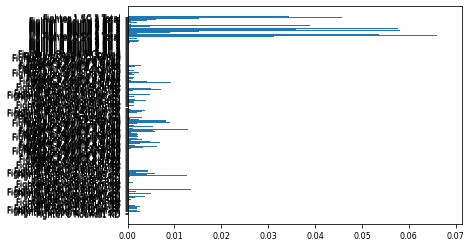

In [57]:
import matplotlib.pyplot as plt

# Visualize importances
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, clf.feature_importances_)

In [58]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 1.0
accuracy_valid = 0.5714285714285714


C:\Users\Jacky Sio\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [59]:
# SVM
from sklearn.svm import SVC

clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

accuracy_train = 0.9230769230769231
accuracy_valid = 0.5714285714285714


C:\Users\Jacky Sio\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [60]:
# FFN
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                6304      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________


In [62]:
X_train = np.asarray(X_train).astype('float32')
y_train = tf.cast(y_train, dtype=tf.int32)
X_valid = np.asarray(X_valid).astype('float32')
y_valid = tf.cast(y_valid, dtype=tf.int32)

In [63]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
2/2 [==============================] - 1s 229ms/step - loss: 10.7002 - accuracy: 0.5385 - val_loss: 10.5405 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 46ms/step - loss: 5.4826 - accuracy: 0.6154 - val_loss: 7.0677 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 38ms/step - loss: 2.8211 - accuracy: 0.6731 - val_loss: 6.1590 - val_accuracy: 0.4286
Epoch 4/100
2/2 [==============================] - 0s 45ms/step - loss: 2.5862 - accuracy: 0.6731 - val_loss: 6.0578 - val_accuracy: 0.4643
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 2.3618 - accuracy: 0.7115 - val_loss: 5.2242 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 1.4303 - accuracy: 0.7500 - val_loss: 4.6428 - val_accuracy: 0.5714
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 0.7886 - accuracy: 0.8269 - val_loss: 4.1432 - val_accuracy: 0.6071
Epoch 8/100
2/2 [

2/2 [==============================] - 0s 36ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 3.0719 - val_accuracy: 0.6071
Epoch 60/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 3.0713 - val_accuracy: 0.6071
Epoch 61/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 3.0727 - val_accuracy: 0.6071
Epoch 62/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 3.0736 - val_accuracy: 0.6071
Epoch 63/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 3.0745 - val_accuracy: 0.6071
Epoch 64/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 3.0746 - val_accuracy: 0.6071
Epoch 65/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 3.0752 - val_accuracy: 0.6071
Epoch 66/100
2/2 [========

In [64]:
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

1/1 [==============================] - 0s 29ms/step - loss: 3.0895 - accuracy: 0.6071


[3.089491128921509, 0.6071428656578064]

## Test out model manually

In [65]:
idx = 6

In [66]:
X_test.iloc[idx]

Fighter 0 Round 1 KD                 0
Fighter 1 Round 1 KD                 0
Fighter 0 Round 1 Sig. str.         12
Fighter 1 Round 1 Sig. str.         10
Fighter 0 Round 1 Sig. str. %     75.0
Fighter 1 Round 1 Sig. str. %     29.0
Fighter 0 Round 1 Total str.        15
Fighter 1 Round 1 Total str.        10
Fighter 0 Round 1 Td                 0
Fighter 1 Round 1 Td                 0
Fighter 0 Round 1 Td %             0.0
Fighter 1 Round 1 Td %             0.0
Fighter 0 Round 1 Sub. att           0
Fighter 1 Round 1 Sub. att           0
Fighter 0 Round 1 Rev.               0
Fighter 1 Round 1 Rev.               0
Fighter 0 Round 1 Ctrl             159
Fighter 1 Round 1 Ctrl               0
Fighter 0 Round 2 KD               0.0
Fighter 1 Round 2 KD               0.0
Fighter 0 Round 2 Sig. str.        5.0
Fighter 1 Round 2 Sig. str.       14.0
Fighter 0 Round 2 Sig. str. %     31.0
Fighter 1 Round 2 Sig. str. %     43.0
Fighter 0 Round 2 Total str.      20.0
Fighter 1 Round 2 Total s

In [67]:
# 0 means fighter 0 won. 1 means fighter 1 won.
y_test.iloc[idx]

Winner    1
Name: 34, dtype: int64

In [68]:
X_test.shape

(40, 196)

In [69]:
X_test.iloc[idx].shape

(196,)

In [70]:
X_test = np.asarray(X_test).astype('float32')
X_test = pd.DataFrame(X_test)

In [71]:
model.predict(np.expand_dims(X_test.iloc[idx], 0))

1/1 [==============================] - 0s 100ms/step


array([[0.984889]], dtype=float32)

## Save data

Store beginning file parameters.
Use current date and time to save files uniquely.

In [72]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%Hh%Mm%Ss")
print("dt_string =", dt_string)	

dt_string = 13-07-2023_20h47m34s


In [73]:
parameters_string = f"NUM_EVENTS_{NUM_EVENTS_INPUT}_DATA_MODE_{DATA_MODE_INPUT}"
print("parameters_string =", parameters_string)	

parameters_string = NUM_EVENTS_10_DATA_MODE_Round by Round


In [74]:
import pickle
filename1 = f"FULL_FIGHT_TABLE_{parameters_string}_{dt_string}.csv"
filename2 = f"FIGHT_TABLE_{parameters_string}_{dt_string}.csv"
filename3 = f"ALL_FIGHTERS_{parameters_string}_{dt_string}.csv"
filename4 = f"RAW_FIGHT_TABLES_LIST_{parameters_string}_{dt_string}.pkl"
print(f"Saving to {filename1} and {filename2} and {filename3} and {filename4}")
FULL_FIGHT_TABLE.to_csv(filename1, index=False)
FIGHT_TABLE.to_csv(filename2, index=False)
ALL_FIGHTERS.to_csv(filename3, index=False)
with open(filename4, 'wb') as handle:
    pickle.dump(RAW_FIGHT_TABLES_LIST, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saving to FULL_FIGHT_TABLE_NUM_EVENTS_10_DATA_MODE_Round by Round_13-07-2023_20h47m34s.csv and FIGHT_TABLE_NUM_EVENTS_10_DATA_MODE_Round by Round_13-07-2023_20h47m34s.csv and ALL_FIGHTERS_NUM_EVENTS_10_DATA_MODE_Round by Round_13-07-2023_20h47m34s.csv and RAW_FIGHT_TABLES_LIST_NUM_EVENTS_10_DATA_MODE_Round by Round_13-07-2023_20h47m34s.pkl


In [75]:
new = pd.read_csv(filename1)

In [76]:
new

Fighter 0 Round 1 KD  Fighter 1 Round 1 KD  Fighter 0 Round 1 Sig. str.  \
0                       0                     1                           22   
1                       0                     0                           34   
2                       0                     1                           27   
3                       0                     0                            2   
4                       0                     0                            2   
5                       0                     0                           11   
6                       0                     0                           16   
7                       0                     0                           33   
8                       0                     0                            3   
9                       0                     0                           17   
10                      0                     0                           14   
11                      0                     0                            5   
12                      0                     0                           31   
13                      0                     0                           29   
14                      0                     0                           26   
15                      0                     0                           24   
16                      0                     0                           21   
17                      0                     0                            1   
18                      0                     0                           38   
19                      0                     0                           37   
20                      0                     0                           21   
21                      0                     0                           35   
22                      0                     0                           13   
23                      0                     0                           15   
24                      0                     0                           21   
25                      0                     0                           14   
26                      1                     0                           30   
27                      0                     0                           20   
28                      0                     0                           19   
29                      0                     0                           20   
30                      0                     0                           41   
31                      0                     0                           13   
32                      0                     0                           15   
33                      0                     0                            9   
34                      0                     0                           12   
35                      0                     0                            7   
36                      1                     0                           18   
37                      0                     0                           14   
38                      0                     0                           17   
39                      1                     0                           23   
40                      0                     0                           34   
41                      0                     0                           42   
42                      0                     0                           28   
43                      0                     0                           60   
44                      0                     0                            3   
45                      0                     0                           10   
46                      0                     0                           19   
47                      0                     0                           14   
48                      0                     0                            1   
49   

In [77]:
with open(filename4, 'rb') as pickle_file:
    new2 = pickle.load(pickle_file)

In [78]:
len(new2[0])

4

## Experimental: Get detailed fighter information

TODO: Get more detailed information about fighters, so we can change the task to fight prediction using fighter stats only. http://ufcstats.com/statistics/fighters?char=a&page=all has little information compared to http://ufcstats.com/fighter-details/33a331684283900f. Still lots to improve. Better features like strikes per minute. Handling nans better. Handling non win/losses better.

In [79]:
def get_all_fighters_detailed():
    '''Get pandas table with detailed information about all UFC fighters (KO's, strikes, etc.)'''
    fighter_detailed_tables = []
    
    # For each letter of the alphabet, get the fighters
    for c in tqdm(ascii_lowercase):
        # Each page has a list of fighter detail urls
        all_fighters_url = f"http://ufcstats.com/statistics/fighters?char={c}&page=all"
        all_fighters_html = urlopen(all_fighters_url).read().decode("utf-8")

        # Regex for "http://ufcstats.com/fighter-details/<alphanumeric>"
        # Eg. "http://ufcstats.com/fighter-details/27541033b97c076d"
        pattern = "\"http://ufcstats.com/fighter-details/[a-zA-Z0-9_]+\""
        urls = re.findall(pattern, all_fighters_html)
        
        # Remove quotes and duplicates
        urls = [url.strip("\"") for url in urls]
        urls = remove_duplicates_keep_order(urls)
        
        # For each fighter detail url, merge together their record information
        # Initially in form "Eddie Alvarez Rafael Dos Anjos", "0 0", "1:10, 0:00"
        # Want just "Eddie Alvarez", "0", "1:10", then convert to numbers
        # Just need to get the first value of each one, then average/sum/aggregate this together
        for url in urls:
            fighter_table = pd.read_html(url)[0].dropna(subset=["Time"], how='all')  # Drop initial row of nans

            # If no fight information, add empty dataframe
            if fighter_table.shape[0] == 0:
                df = pd.DataFrame()
                fighter_detailed_tables.append(df)
                continue
                
            # Preprocess certain values for consistency
            # TODO: Handle this better, perhaps keep more information
            fighter_table = fighter_table.drop(columns=["Method", "Event"])
            fighter_table.loc[~fighter_table['W/L'].isin(['win', 'loss']), 'W/L'] = "-1 -1"
            fighter_table.loc[fighter_table['W/L'] == 'win', 'W/L'] = "1  1"
            fighter_table.loc[fighter_table['W/L'] == 'loss', 'W/L'] = "0  0"
            times = [int(min_) * 60 + int(sec) for min_, sec in fighter_table['Time'].str.split(':')]
            fighter_table['Time'] = [f"{t}  {t}" for t in times]
            
            # Parse each row to remove the other fighter's information
            new_rows = []
            for i, row in fighter_table.iterrows():
                # Get df of one round
                df = pd.DataFrame(row, columns=fighter_table.columns)
                values = [row[col] for col in df.columns]
                df = pd.DataFrame([values], columns=fighter_table.columns)
                df = process_fight(df)
                new_rows.append(df)

            # Put rows together, then only keep Fighter 0, then remove "Fighter 0 "
            totals_df = pd.concat(new_rows)
            totals_df = totals_df.loc[:, totals_df.columns.str.contains('Fighter 0')]
            totals_df.columns = [col.replace("Fighter 0 ", "") for col in totals_df.columns]
            totals_df = totals_df.replace("^-+", np.nan, regex=True)  # Replace -- and --- with nan

            # Summarize fighter in 1 row
            new_columns = []
            new_row = []
            for col in totals_df.columns:
                if col == "Name":
                    new_columns.append(col)
                    new_row.append(totals_df[col].iloc[0])
                else:
                    total_col = f"{col} Total"
                    avg_col = f"{col} Avg"
                    new_columns.extend([total_col, avg_col])
                    total = totals_df[col].sum()
                    avg = totals_df[col].mean()
                    new_row.extend([total, avg])
            totals_df = pd.DataFrame([new_row], columns=new_columns)

            fighter_detailed_tables.append(totals_df) 
            break  # Remove this when ready
    all_fighters = pd.concat(fighter_detailed_tables)
    return all_fighters

In [80]:
x = get_all_fighters_detailed()

  4%|███▏                                                                               | 1/26 [00:01<00:43,  1.76s/it]

Tom Aaron  Matt Ricehouse
Tom Aaron  Eric Steenberg


  8%|██████▍                                                                            | 2/26 [00:03<00:45,  1.90s/it]

Niklas Backstrom  Noad Lahat
Niklas Backstrom  Mike Wilkinson
Niklas Backstrom  Tom Niinimaki
Yan Cabral  Reza Madadi
Yan Cabral  Johnny Case
Yan Cabral  Naoyuki Kotani
Yan Cabral  Zak Cummings


 12%|█████████▌                                                                         | 3/26 [00:06<00:47,  2.08s/it]

Yan Cabral  David Mitchell
Yan Cabral  Kazushi Sakuraba


 15%|████████████▊                                                                      | 4/26 [00:07<00:42,  1.93s/it]

Sarah D'alelio  Ronda Rousey


 19%|███████████████▉                                                                   | 5/26 [00:08<00:34,  1.66s/it]

Ben Earwood  Chris Lytle
Edward Faaloloto  Terry Etim
Edward Faaloloto  Michael Johnson
Edward Faaloloto  Anthony Njokuani


 27%|██████████████████████▎                                                            | 7/26 [00:12<00:32,  1.73s/it]

James Gabert  Mike Swick


 31%|█████████████████████████▌                                                         | 8/26 [00:14<00:30,  1.69s/it]

Chelsea Hackett  Victoria Leonardo
Al Iaquinta  Bobby Green
Al Iaquinta  Dan Hooker
Al Iaquinta  Donald Cerrone
Al Iaquinta  Kevin Lee
Al Iaquinta  Khabib Nurmagomedov
Al Iaquinta  Diego Sanchez
Al Iaquinta  Jorge Masvidal
Al Iaquinta  Joe Lauzon
Al Iaquinta  Ross Pearson
Al Iaquinta  Rodrigo Damm
Al Iaquinta  Mitch Clarke
Al Iaquinta  Kevin Lee
Al Iaquinta  Piotr Hallmann
Al Iaquinta  Ryan Couture
Al Iaquinta  Michael Chiesa


 35%|████████████████████████████▋                                                      | 9/26 [00:17<00:37,  2.21s/it]

Yves Jabouin  Felipe Arantes
Yves Jabouin  Thomas Almeida
Yves Jabouin  Mike Easton
Yves Jabouin  Eddie Wineland
Yves Jabouin  Dustin Pague
Yves Jabouin  Brad Pickett
Yves Jabouin  Jeff Hougland
Yves Jabouin  Walel Watson
Yves Jabouin  Ian Loveland
Yves Jabouin  Pablo Garza
Yves Jabouin  Brandon Visher
Yves Jabouin  Mark Hominick


 38%|███████████████████████████████▌                                                  | 10/26 [00:20<00:39,  2.46s/it]

Yves Jabouin  Raphael Assuncao


 42%|██████████████████████████████████▋                                               | 11/26 [00:22<00:33,  2.24s/it]

Patrick Kaase  Jarrod Kwitty


 46%|█████████████████████████████████████▊                                            | 12/26 [00:23<00:28,  2.04s/it]

Achmed Labasanov  Gary Goodridge
Dong Hyun Ma  Omar Morales
Dong Hyun Ma  Scott Holtzman
Dong Hyun Ma  Devonte Smith
Dong Hyun Ma  Damien Brown
Dong Hyun Ma  Takanori Gomi
Dong Hyun Ma  Brendan O'Reilly
Dong Hyun Ma  Marco Polo Reyes
Dong Hyun Ma  Dominique Steele


 50%|█████████████████████████████████████████                                         | 13/26 [00:27<00:34,  2.65s/it]

Katsuhiko Nagata  Vitor Ribeiro
Katsuhiko Nagata  Shinya Aoki
Katsuhiko Nagata  Artur Oumakhanov
Katsuhiko Nagata  Yoshihiro Akiyama


 54%|████████████████████████████████████████████▏                                     | 14/26 [00:30<00:30,  2.56s/it]

Jake O'Brien  Gegard Mousasi
Jake O'Brien  Jon Jones
Jake O'Brien  Christian Wellisch
Jake O'Brien  Cain Velasquez
Jake O'Brien  Andrei Arlovski
Jake O'Brien  Heath Herring
Jake O'Brien  Josh Shockman
Jake O'Brien  Kristof Midoux


 62%|██████████████████████████████████████████████████▍                               | 16/26 [00:34<00:23,  2.39s/it]

Raquel Pa'aluhi  Sara McMann
Qiu Lun  SeungGuk Choi
Qiu Lun  Wallen Del Rosario
Qiu Lun  Erisson Ferreira


 65%|█████████████████████████████████████████████████████▌                            | 17/26 [00:36<00:19,  2.19s/it]

Benji Radach  Ovince Saint Preux
Benji Radach  Scott Smith
Benji Radach  Murilo Rua
Benji Radach  Sean Sherk
Benji Radach  Nick Serra
Benji Radach  Steve Berger


 69%|████████████████████████████████████████████████████████▊                         | 18/26 [00:39<00:19,  2.38s/it]

Yusup Saadulaev  Hideo Tokoro
Yusup Saadulaev  Rodolfo Marques Diniz


 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [00:41<00:16,  2.39s/it]

Osamu Tachihikari  Gary Goodridge


 77%|███████████████████████████████████████████████████████████████                   | 20/26 [00:43<00:13,  2.18s/it]

Takeru Uchida  Shaun Etchell


 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [00:44<00:09,  1.96s/it]

Richie Vaculik  Danny Martinez
Richie Vaculik  Louis Smolka
Richie Vaculik  Roldan Sangcha'an
Richie Vaculik  Justin Scoggins


 85%|█████████████████████████████████████████████████████████████████████▍            | 22/26 [00:47<00:08,  2.08s/it]

James Wade  Booker DeRousse


 88%|████████████████████████████████████████████████████████████████████████▌         | 23/26 [00:48<00:05,  1.95s/it]

Rubens Xavier  Thiago Silva


 92%|███████████████████████████████████████████████████████████████████████████▋      | 24/26 [00:50<00:03,  1.70s/it]

Jamie Yager  Rich Attonito


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [00:51<00:01,  1.59s/it]

Luke Zachrich  Daniel Kelly
Luke Zachrich  Guilherme Vasconcelos
Luke Zachrich  Caio Magalhaes


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:53<00:00,  2.05s/it]


In [81]:
x.head()

W/L Total   W/L Avg  Kd Total    Kd Avg  Str Total    Str Avg  Td Total  \
0          1  0.500000       0.0       NaN        0.0        NaN       0.0   
0          1  0.333333       0.0  0.000000       23.0   7.666667       4.0   
0          3  0.500000       1.0  0.166667      147.0  24.500000      14.0   
0          0  0.000000       0.0  0.000000        1.0   1.000000       0.0   
0          1  1.000000       0.0  0.000000        5.0   5.000000       2.0   

     Td Avg  Sub Total  Sub Avg  Round Total  Round Avg  Time Total  \
0       NaN        0.0      NaN            0        0.0         356   
0  1.333333        3.0      1.0            0        0.0         634   
0  2.333333        6.0      1.0            0        0.0        1364   
0  0.000000        0.0      0.0            0        0.0          25   
0  2.000000        0.0      0.0            0        0.0         300   

     Time Avg              Name  
0  178.000000         Tom Aaron  
0  211.333333  Niklas Backstrom  
0  227.333333        Yan Cabral  
0   25.000000    Sarah D'alelio  
0  300.000000       Ben Earwood